# Milestone 2 - Data gathering and preprocessing

## 1. Narrowing down the research question

### Research Questions

In this research project we will try to analyse a corpus of popular songs to try to identify  chords differences between verses and choruses. We will try to  answer the following research questions :
<ol>
<li>Does the chord distribution of the choruses differ from the one in the verses?</li>
<li>Is there a different chord sequence distribution in the choruses compared to the verses?</li>
<li>How are these distributions evolving over time? </li>
</ol>

In the first question we want to know if a difference exists in terms of chords statistic. Are we more likely to find a specific chord in the choruses? Are fewer different chords used in the chorus compared to the other parts of a song? <br> 
For the second one we want to have a more melodic insight. Can we find specific patterns? Is the Markov model derived from the chorus different from its counterparts? <br>
In the third one the focus is on the time dimension. We want to know if the results of the two previous answers change over time. Were chorus closer to verses in 1968 than in 1985? How does each chord evolve in relation to the others? Do we find a sequence that appeared while other disappeared? 

These are all the underlying questions we want to answer under our main research questions.  

These questions relate to our original idea to fully characterize a chorus over the years, especially in comparison with verses. We now want to focus specifically on the chords to differentiate these different parts, while keeping the temporal dimension as a potential factor to observe changes.

### Dataset presentation

To give us the means to answer our questions, we have selected a dataset containing approximately 900 Pop-Rock songs in the top Billboard charts from the 60s to the 90s. They are simple text files with the following informations : 
* Release date
* Song title 
* Artist name
* Labels for the different parts of the song (such as chorus or verse)
* Timestamp of each musical phrase beginning
* Chords

### Procedure

We will use the chorus/verse annotations to classify the chords in each group. This will allow us to divide the chords in two groups and compute statistics and distributions for each of them. As discussed in the research questions, we will start with a basic characterization, simply comparing which chords appear in which section. We will then move deeper and compare the distributions of chords as well as the Markov models. These will be computed at least with bigrams, perhaps with higher-n n-grams depending on the number of chords in each section (as it makes little sense to use n-grams with n close to the number of chords in a given section).

The metadata, especially the release date, will be used to study the evolution over time of the previously discussed statistics. Depending on the distribution of songs over the years, time analysis will be discussed either over years or over decades.

### Possible outcomes and confidence measures

The different outcomes we can reasonably expect are: 
<ul>
    <li> <strong>Null results:</strong> There are no significant differences between choruses and verses and no evolution over time. This could be explained by a bias in the corpus toward a specific Pop-Rock genre using the same chords all the time or maybe there is indeed no difference in the chords used in a chorus and the ones used in verses, which would constitute an answer for our questions. </li>
<li> <strong>Narrow chorus chord distribution:</strong> Since the chorus has to be immediately recognized as one, maybe the composers make more extensive use of a sub group of the chords to ensure it. The same reasoning could be applied to the chord sequences: perhaps some specific ones will be more dominant in the chorus.</li>
<li> <strong>Temporal evolution:</strong> It will be interesting to see if the differences between verse and chorus change over the years. This evolution, if present, could be linear or oscillating. A linear narrowing would imply that choruses are becoming more and more similar or verse more and more diverse. An oscillating pattern would be interesting as musical phenomenon could appear and disappear.</li>
</ul>

Statistical tests will be used throughtout our analysis to check if our findings are statistically relevant. Error bars will also be included in all our graphics to avoid wrong conclusions. Of course the relative small size of our corpus will influence our results but only further analysis can reveal if significant results can still be found.

## 2. Gathering the data
The dataset has been created by [1] and corresponds to a random sample of 890 Billboard chart slots presented at ISMIR 2011 and MIREX 2012. Due to the nature of the sampling algorithm, there are some duplicates and this results in only 740 distinct songs. According to the authors, training algorithms that assume independent, identically distributed data should retain the duplicates.<br> This dataset is publicly available at https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/ and can be downloaded in various formats. Different features are given by the authors. In this project we will use metadata and chords annotations. 
The first dataset used is the index to the dataset (csv format), containing the following fields:
<ul>
<li><b>id</b>, the index for the sample entry.</li>
<li><b>chart_date</b>, the date of the chart for the entry.</li>
<li><b>target_rank</b>, the desired rank on that chart.</li>
<li><b>actual_rank</b>, the rank of the song actually annotated, which may be up to 2 ranks higher or lower than the target rank [1, 2].</li>
<li><b>title</b>, the title of the song annotated.</li>
<li><b>artist</b>, the name of the artist performing the song annotated.</li>
<li><b>peak_rank</b>, the highest rank the song annotated ever achieved on the Billboard Hot 100.</li>
<li><b>weeks_on_chart</b>, the number of weeks the song annotated spent on the Billboard Hot 100 chart in total.</li>
</ul>

The main dataset comprehends chords, structure, instrumentation, and timing, given in a txt format. The annotation for each song begins with a header containing the title of the song, the name of the artist, the metre and the tonic pitch class of the opening key. In the main body, each line consists of a single phrase and begins with its timestamp, followed by the chords. This requires us to design a specific parser, as will be discussed in the next section.<br>
We downloaded the two datasets which constitutes the whole of their database so we have the maximum from this source. It is not excluded that we find some additional ones to perform further analysis. As for now we will try to get as much stastitically relevant information from this source.

[1]: John Ashley Burgoyne, Jonathan Wild, and Ichiro Fujinaga, ‘An Expert Ground Truth Set for Audio Chord Recognition and Music Analysis’, in Proceedings of the 12th International Society for Music Information Retrieval Conference, ed. Anssi Klapuri and Colby Leider (Miami, FL, 2011), pp. 633–38

## 3. Data format

The goal of this question is to load the data and have a look at it. A specific parser is designed to do this automatically, in order to extract and store in a Pandas dataframe all the relevant informations and musical features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px
import seaborn as sns
import researchpy as rp

### Metadata

In [2]:
metadata_df = pd.read_csv("data/billboard-2.0-index.csv")
metadata_df.head(10)

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN
5,6,1980-08-02,15,16.0,The Rose,Bette Midler,3.0,25.0
6,7,1972-10-07,37,NaN,NaN,NaN,NaN,NaN
7,8,1963-04-13,67,NaN,NaN,NaN,NaN,NaN
8,9,1991-05-25,48,NaN,NaN,NaN,NaN,NaN
9,10,1984-03-24,49,51.0,An Innocent Man,Billy Joel,10.0,18.0


In [3]:
print('There are %d entries in the index table.' %len(metadata_df))

There are 1300 entries in the index table.


In [4]:
print('There are %d entries with a given title.' %metadata_df.title.isna().value_counts()[0])

There are 890 entries with a given title.


In [5]:
print('There are %d entries with a given artist.' %metadata_df.artist.isna().value_counts()[0])

There are 890 entries with a given artist.


In [6]:
print('There are %d entries with a given chart date.' %metadata_df.chart_date.isna().value_counts()[0])

There are 1300 entries with a given chart date.


In [7]:
months = {'01':'January', 
          '02':'February',
          '03':'March',
          '04':'April',
          '05':'May',
          '06':'June',
          '07':'July',
          '08':'August',
          '09':'September',
          '10':'October',
          '11':'November',
          '12':'December'}
def format_date(date):
    year = date[:4]
    month = date[5:7]
    day = date[-2:]
    if day == '01':
        suffix = 'st'
    elif day == '02':
        suffix = 'nd'
    elif day == '03':
        suffix = 'rd'
    else:
        suffix = 'th'
        
    if day[0] == '0':
        day = day[1]
    
    date_string = months[month] + ' ' + day + suffix + ', ' + year
    return(date_string)

#Test
format_date('1958-08-04')

'August 4th, 1958'

In [8]:
print('The songs range from %s to %s.' %(format_date(metadata_df.chart_date.min()), format_date(metadata_df.chart_date.max())))

The songs range from August 18th, 1958 to November 16th, 1991.


### Parser 

In [9]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

#This is dependant of "metre" in the txt files.
METRE = "metre"

#Create a new dictionary from two other
def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

#Create a row of the futur df as a dictionary
def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

#Generate the attributes of a given line and update the sequence counter
def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] \
            and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        
        #Z is a structure, not a type.
        if header_items[1].strip().strip(",") == "Z":
            result[STRUCTURE] = header_items[1].strip().strip(",")
        else:
            result[TYPE] = header_items[1].strip().strip(",")
            
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [10]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            #Special metric (experimental)
                            old_metre = persistent_attributes.get(METRE)
                            if re.match("^\(\d/\d\)$", chords[0]):
                                persistent_attributes[METRE] = str(chords[0][1]) + "/" + str(chords[0][3])
                                chords = chords[1:]
                            
                            if len(chords) == 1:
                                duration = "measure"
                            elif len(chords) == 2 and persistent_attributes[METRE] in ["4/4","12/8"]:
                                duration = "half-measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
                            persistent_attributes[METRE] = old_metre
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [11]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [12]:
collection_df = create_whole_collection_df()

In [13]:
collection_df.sample(10)

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,measure_id,chord_id,chord,duration,instrument,elided,repetition
19162,207,Back in the High Life Again,Steve Winwood,4/4,D,19,138.791655328,bridge,7,D,50,94,A:sus4(b7),measure,voice,NaN,NaN
39264,393,Misunderstanding,Genesis,4/4,C,25,113.168253968,bridge,6,B,40,106,Ab:maj,beat,voice,NaN,NaN
66192,663,He's so shy,Pointer Sisters,4/4,C,22,124.654739229,chorus,5,A,61,81,Ab:maj7,half-measure,voice,NaN,NaN
92115,903,Be My Baby,The Ronettes,4/4,E,13,67.397346938,bridge,6,C,28,28,G#:7,measure,NaN,NaN,NaN
15785,177,I've Got Love On My Mind,Nathalie Cole,4/4,Db,12,67.114897959,verse,3,B,19,43,Db:maj,half-measure,voice,NaN,NaN
46296,464,Flesh For Fantasy,Billy Idol,4/4,B,32,246.399659863,verse,10,B,98,204,"E:sus4(b7,9,13)",beat,voice,NaN,NaN
101970,1019,The Arms Of Orion,Prince & Sheena Easton,4/4,D,14,75.249523809,verse,4,B,48,55,A:sus4(b7),half-measure,saxophone,NaN,NaN
9782,104,We Two,Little River Band,4/4,A,8,15.844058956,verse,2,B,8,8,A:5,measure,(voice,NaN,NaN
27915,292,Chicago,25 or 6 to 4,4/4,A,30,169.263015873,instrumental,7,D,107,130,E:7,half-measure,NaN,NaN,NaN
14194,155,Forever Man,Eric Clapton,4/4,D,21,137.117913832,verse,8,B,65,95,C:maj,half-measure,voice,NaN,NaN


### Exploratory statistical analysis

If we look at the number of sample per year we have, we see it's pretty well distributed. 

In [14]:
years=metadata_df.chart_date.map(lambda y:pd.to_datetime(y).year).value_counts(sort=False)
years.iplot(kind='bar', title="Number of sample song per year", xTitle="Year", yTitle="Samples")




In [15]:
collection_df.chord.value_counts().head(24).iplot(kind='bar',title="Overall chord occurence ditribution",xTitle="Chord",yTitle="Occurence")

In [16]:
collection_df[collection_df["section_type"]=="chorus"].chord.value_counts().head(20).iplot(kind='bar',title="Chorus chord occurence ditribution",xTitle="Chord",yTitle="Occurence")

In [17]:
print("Number of songs that contain a chorus : %s" %str(np.sum(collection_df[[SONG_ID,TYPE]].drop_duplicates()[TYPE] == "chorus")))

print("Number of songs that contain a verse : %s" %str(np.sum(collection_df[[SONG_ID,TYPE]].drop_duplicates()[TYPE] == "verse")))

unique_section_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)
print("Number of songs that contain both : %s" %str(np.sum(unique_section_songs.apply(lambda l : "chorus" in l and "verse" in l))))

Number of songs that contain a chorus : 739
Number of songs that contain a verse : 858
Number of songs that contain both : 712


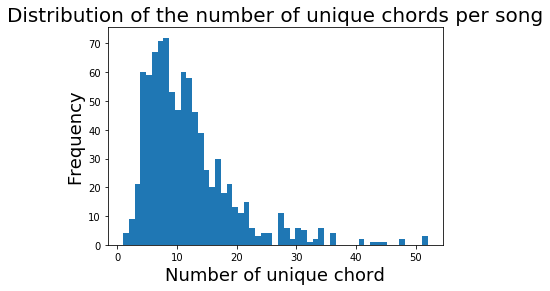

In [18]:
#Basic statistics: Number of unique chords per songs
unique_chord_songs = collection_df[[SONG_ID,CHORD]].drop_duplicates().groupby(SONG_ID).count()
n_bins = int(unique_chord_songs.max())+1
unique_chord_songs.plot.hist(bins = n_bins, legend = False)
plt.title('Distribution of the number of unique chords per song', fontsize = 20)
plt.xlabel('Number of unique chord', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()

# Milestone 3

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
    <div style = "font-size:25px; text-align:center;"><strong>Final processing</strong></div>
    <div>
        The first step for this milestone is to finish the processing of our dataset in order to obtain a dataframe containing all the chords of all songs that have both a verse and a chorus. We also add a parser for the chord notation used to better understand it. Thus we will:
            <ul>
                <li>parse the notation of the chords used in the dataset</li>
                <li>implement the relative-to-tonic pitch class</li>
                <li>discard all songs without both a verse and a chorus</li>
                <li>split the dataframe to have a row per beat</li>
                <li>create a function to squeeze all chords of a song in a list</li>
            </ul>
    </div>
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Parser for the chords</strong>
</div> 

We also define a parser to better handle the chords. This is based on the notation defined in http://ismir2005.ismir.net/proceedings/1080.pdf. Some notations are also added by the authors of the dataset and therefore included to handle all the 978 unique chords in the dataset. 

In [19]:
print('There are %d unique chords in the dataset.' %len(collection_df.chord.unique()))

There are 978 unique chords in the dataset.


In [20]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [21]:
collection_df['chord_dic'] = collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
collection_df.drop(columns = 'chord_dic', inplace = True)
#df = collection_df[['song_id', 'title', 'artist', 'tonic', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

In [22]:
collection_df.head()

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,...,chord,duration,instrument,elided,repetition,root,shorthand,degree_list,bass,N
0,3,I Don't mind,James Brown,6/8,C,5,0.0,silence,0,NaN,...,NaN,NaN,NaN,NaN,NaN,,nan,[],,False
1,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,A:min,measure,NaN,NaN,NaN,A,min,[],,False
2,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,A:min,measure,NaN,NaN,NaN,A,min,[],,False
3,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,C:maj,measure,NaN,NaN,NaN,C,maj,[],,False
4,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,C:maj,measure,NaN,NaN,NaN,C,maj,[],,False


<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of new columns fo relative-to-tonic roots</strong>
</div> 

In [23]:
TPC_DIC = {"Cb":11,"C":0,"C#":1,"Db":1,"D":2,"D#":3,"Eb":3,"E":4,"E#":5,"Fb":4,"F":5,"F#":6,
           "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11,"B#":0}

In [24]:
collection_df["root_tpc"] = collection_df.root.apply(lambda r : TPC_DIC.get(r))
collection_df = collection_df.astype({"root_tpc":"Int64"})

In [25]:
collection_df["relative_root_tpc"] =\
collection_df.apply(lambda row: (row["root_tpc"] - TPC_DIC.get(row["tonic"]))%12,axis = 1)

In [26]:
collection_df = collection_df.fillna({REPETITION:1})

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of the dataframe with only songs that have both a verse and a chorus</strong>
</div> 

In [27]:
valid_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)\
.apply(lambda l: "chorus" in l and "verse" in l)

In [28]:
d_collection_df = collection_df.merge(valid_songs.reset_index().rename(columns = {TYPE:"valid"}),on = SONG_ID)
d_collection_df = d_collection_df[d_collection_df.valid].drop(columns = 'valid')

In [29]:
print('The corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The corpus has 712 songs.



<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Dropping duplicates songs</strong>
</div>


In [30]:
ids_to_keep = d_collection_df[["song_id","title"]].drop_duplicates("title")["song_id"].values
d_collection_df = d_collection_df[d_collection_df.song_id.isin(ids_to_keep)]

In [31]:
print('The final corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The final corpus has 585 songs.


<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of a one-row-per-beat dataframe</strong>
</div> 

Duration of measure: all metre in the corpus are regular except song 700 (5/8 = 3 + 2). This was counted as two beats.

In [32]:
def weight_row(metre, duration, repetition):
    """
    Indicate to how many beats in total a chord described on a dataframe's row correspond.
    Careful ! The chords are non-successive in case of repetition
    """
    num, denom = metre.split("/")
    
    if metre == "5/8": #Specific to this dataset
        beat_per_measure = 2
    else:
        beat_per_measure = int(num)/(1 if int(denom) == 4 else 3)
    
    if duration == "measure":
        return beat_per_measure*(repetition)
    
    elif duration == "half-measure":
        return beat_per_measure/2*(repetition)
    
    elif duration == "beat":
        return repetition
    
    else:
        return 0

def successive_repetition_row(metre,duration):
    """
    Indicate on how many successive beats a chord is present
    """
    return weight_row(metre,duration,repetition=1)

In [33]:
# Creation of one-row-per-bit dataframe
N_SUCC_BEATS = "n_succ_beats"

d_collection_df[N_SUCC_BEATS] = d_collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)
d_collection_df = d_collection_df.astype({N_SUCC_BEATS:"Int64"})

In [34]:
from tqdm import tqdm

def create_beats_df(d_collection_df):
    beats_dics = []
    repetition_flag = False
    repeted_dics = []
    repetition_line = np.PINF
    repetition_song = np.PINF
    for i in tqdm(d_collection_df.reset_index().index):

        if repetition_flag == True and\
(repetition_line != d_collection_df.iloc[i][LINE_NUMBER] or repetition_song != d_collection_df.iloc[i][SONG_ID]):

            for r in range(repetition_n):
                beats_dics += repeted_dics

            repetition_flag = False
            repeted_dics = []
            repetition_line = np.PINF
            repetition_song = np.PINF
        
        
        if d_collection_df.iloc[i][REPETITION] == 1 :

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                beats_dics.append(d_collection_df.iloc[i].to_dict())

        else:

            repetition_flag = True
            repetition_line = d_collection_df.iloc[i][LINE_NUMBER]
            repetition_song = d_collection_df.iloc[i][SONG_ID]
            repetition_n = d_collection_df.iloc[i][REPETITION]

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                repeted_dics.append(d_collection_df.iloc[i].to_dict())

    beats_collection_df = pd.DataFrame(beats_dics)
    
    return beats_collection_df

In [35]:
beats_collection_df = create_beats_df(d_collection_df)
beats_collection_df = beats_collection_df.drop(N_SUCC_BEATS,axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 87919/87919 [01:12<00:00, 1214.14it/s]


Let's add the relative chord (using the relative root tpc previously obtained).

In [36]:
beats_collection_df['relative_chord'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'] + beats_collection_df['bass']

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> the final dataframe beats_collection_df has the following properties:
    <ul>
        <li>each row corresponds to a beat and thus to a chord played</li>
        <li>only songs with both a verse and a chorus are kept</li>
        <li>all elements of a chord (root, quality, degree list and bass note) are given</li>
    </ul>
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Squeeze function</strong>
</div> 

As a last processing step, we define a function to obtain a dataframe with all the chords of a song squeezed in its various sections (intro, first verse, chorus, second verse...). This will be helpful later in our analysis.

In [313]:
#The squeeze function returns a dataframe with the all the chords of a song squeezed in a row dependent on a subgroup
# of the section type. Default is "none" and will not filter any type of songs.
#try subgroup="chorus" or subgroup="verse"

def compress(s) :
    return s.dropna().to_list()

def squeeze(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    df_local = df_local.groupby(["song_id","title"])[["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]].agg(compress).reset_index()
    #df_local["relative_chord"] = df_local["relative_root_tpc"].astype(str) + df_local["shorthand"] + df_local["bass"].astype(str)
    '''
    chords = df_local.groupby(["song_id","title"]).chord.agg(compress).reset_index()[['song_id', 'chord']]
    roots = df_local.groupby(["song_id","title"]).root.agg(compress).reset_index()[['song_id', 'root']]
    shorthands = df_local.groupby(["song_id","title"]).shorthand.agg(compress).reset_index()[['song_id', 'shorthand']]
    relative_roots = df_local.groupby(["song_id", "title"]).relative_root_tpc.agg(compress).reset_index()[['song_id', 'relative_root_tpc']]
    '''
    
    #return chords.merge(roots, on = 'song_id').merge(shorthands, on = 'song_id').merge(relative_roots, on = 'song_id')
    return df_local.drop_duplicates(subset = ['title'])

In [314]:
squeeze(beats_collection_df).head()

,song_id,title,chord,root,shorthand,bass,relative_root_tpc,relative_chord,agg_chord_label
0,4,You've got a Friend,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...","[Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , 5, 5, 5, 5, , , , , , , , , , , , , 5...","[0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma..."
1,10,An Innocent Man,"[C:maj, C:maj, C:maj, C:maj, C:maj, C:maj, C:m...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma..."
2,12,Lookin' for Love,"[E:min, E:min, E:min, E:min, F#:min, F#:min, F...","[E, E, E, E, F#, F#, F#, F#, G, G, G, G, A, A,...","[min, min, min, min, min, min, min, min, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...","[2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi...","[2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi..."
3,16,She Bop,"[A:min, A:min, A:min, A:min, A:min, A:min, A:m...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...","[min, min, min, min, min, min, min, min, min, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi...","[0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi..."
4,18,Kiss On My List,"[C:maj, C:maj, G:maj/11, G:maj/11, A:min/b3, A...","[C, C, G, G, A, A, G, G, C, C, C, C, C, C, C, ...","[maj, maj, maj, maj, min, min, maj, maj, min7,...","[, , 11, 11, b3, b3, 11, 11, , , , , , , , , ,...","[0.0, 0.0, 7.0, 7.0, 9.0, 9.0, 7.0, 7.0, 0.0, ...","[0.0maj, 0.0maj, 7.0maj11, 7.0maj11, 9.0minb3,...","[0.0maj, 0.0maj, 7.0maj, 7.0maj, 9.0min, 9.0mi..."


In [315]:
#squeeze section allows you to squeeze the sections of songs
def squeeze_section(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    
    df_local = df_local.groupby(["song_id","title","sequence_id","section_type"])\
                [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]].agg(compress).reset_index()
    df_local['sequence_id'] = df_local['song_id'].astype(str) + ":" + df_local['sequence_id'].astype(int).astype(str)
    
    return df_local

In [316]:
squeeze_section(beats_collection_df).head()

,song_id,title,sequence_id,section_type,chord,root,shorthand,bass,relative_root_tpc,relative_chord,agg_chord_label
0,4,You've got a Friend,4:1,intro,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...","[Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , 5, 5, 5, 5, , , , , , , , ]","[0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma..."
1,4,You've got a Friend,4:2,verse,"[F:min, F:min, F:min, F:min, C:7/5, C:7/5, C:7...","[F, F, F, F, C, C, C, C, F, F, C, C, F, C, F, ...","[min, min, min, min, 7, 7, 7, 7, min, min, 7, ...","[, , , , 5, 5, , , , , 5, 5, b3, 5, , , , , , ...","[9.0, 9.0, 9.0, 9.0, 4.0, 4.0, 4.0, 4.0, 9.0, ...","[9.0min, 9.0min, 9.0min, 9.0min, 4.075, 4.075,...","[9.0min, 9.0min, 9.0min, 9.0min, 4.0other, 4.0..."
2,4,You've got a Friend,4:3,pre-chorus,"[G:hdim7, G:hdim7, G:hdim7, G:hdim7, C:7, C:7,...","[G, G, G, G, C, C, C, C, F, F, C, C, F, C, F, ...","[hdim7, hdim7, hdim7, hdim7, 7, 7, 7, 7, min, ...","[, , , , , , , , , , 5, 5, b3, 5, , , , , , , ...","[11.0, 11.0, 11.0, 11.0, 4.0, 4.0, 4.0, 4.0, 9...","[11.0hdim7, 11.0hdim7, 11.0hdim7, 11.0hdim7, 4...","[11.0other, 11.0other, 11.0other, 11.0other, 4..."
3,4,You've got a Friend,4:4,chorus,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Ab:7, Ab:7, A...","[Ab, Ab, Ab, Ab, Ab, Ab, Ab, Ab, Db, Db, Db, D...","[maj, maj, maj, maj, 7, 7, 7, 7, maj, maj, maj...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.07, 0.07, 0...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0other, 0.0..."
4,4,You've got a Friend,4:5,bridge,"[Gb:maj(9), Gb:maj(9), Gb:maj(9), Gb:maj(9), D...","[Gb, Gb, Gb, Gb, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[10.0, 10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 5.0, 0...","[10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5...","[10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5..."


We can now move to the exploratory analysis.

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
    <div style = "font-size:25px; text-align:center;"><strong>Chord distribution</strong></div>
    <div>
        The first axe of exploration is the most basic one: simply counting. In this section we will look at:
            <ul>
                <li>the most common chords used in the songs</li>
                <li>the distribution of unique chords in the songs</li>
                <li>the roots of the chords</li>
                <li>the quality of the chords</li>
                <li>the bass notes of the chords</li>
                <li>the Bag of Words representation of the songs</li>
            </ul>
    </div>
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Most common chords used</strong>
</div> 

We can start by finding the most used chords in a given section. By default we look at the 50 most common chords.

In [39]:
def chord_distribution(df, section = 'verse', top = 50):
    title = 'Chord distribution in the ' + section
    plt.figure(figsize = (16,6))
    df[df.section_type == section].chord.value_counts().iloc[:top].plot(kind='bar')
    plt.title(title, fontsize = 20)
    plt.xlabel('Chord', fontsize = 18)
    plt.xticks(rotation = 50)
    plt.ylabel('Number of chords', fontsize = 18)

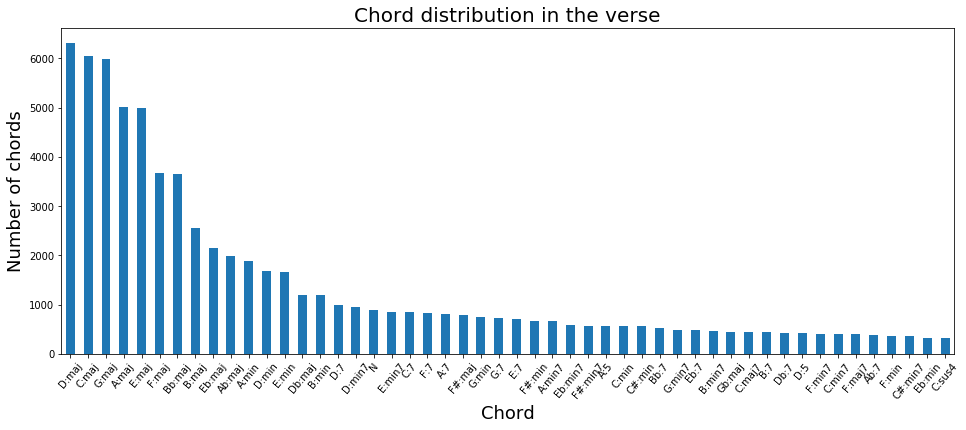

In [40]:
chord_distribution(beats_collection_df, 'verse')

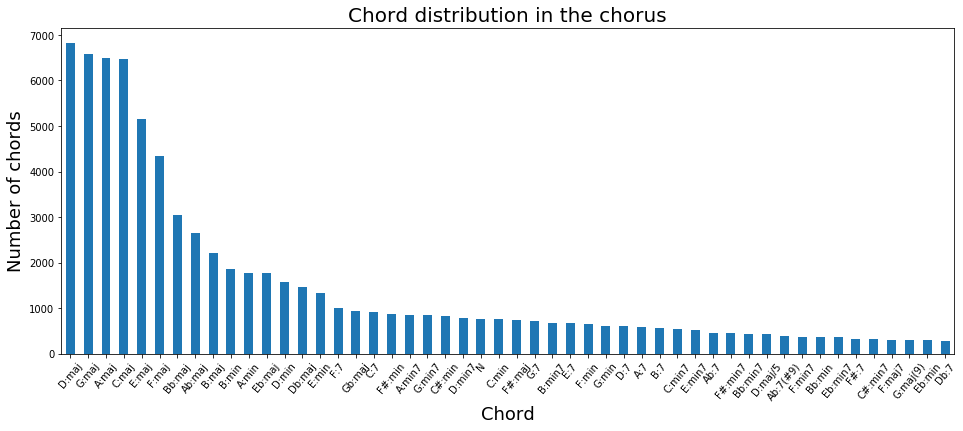

In [41]:
chord_distribution(beats_collection_df, 'chorus')

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Distribution of unique chords</strong>
</div> 

We can also look at the distribution of unique chords used in songs.

In [42]:
def GetUniqueChords(df):
    return df.groupby('song_id').chord.unique().map(lambda x: len(x))

In [43]:
def unique_chords_section(df, section = 'verse'):
    unique_chords = GetUniqueChords(df[df.section_type == section])
    n_bins = int(unique_chords.max()) + 1
    unique_chords.plot.hist(bins = n_bins, legend = False)
    title = 'Distribution of the number of unique chords per song in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Number of unique chords used', fontsize = 18)
    plt.ylabel('Frequency', fontsize = 18)
    plt.show()
    
    print('Statistics:')
    print(unique_chords.describe())
    
    return (unique_chords.describe()['mean'], unique_chords.describe()['std']/np.sqrt(unique_chords.describe()['count']))

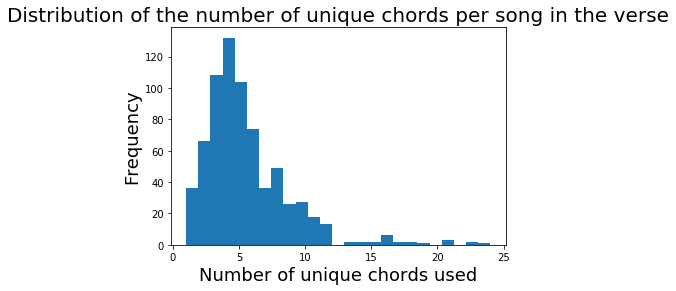

Statistics:
count    712.000000
mean       5.460674
std        3.443925
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       24.000000
Name: chord, dtype: float64


In [44]:
stats_verse = unique_chords_section(beats_collection_df, 'verse')

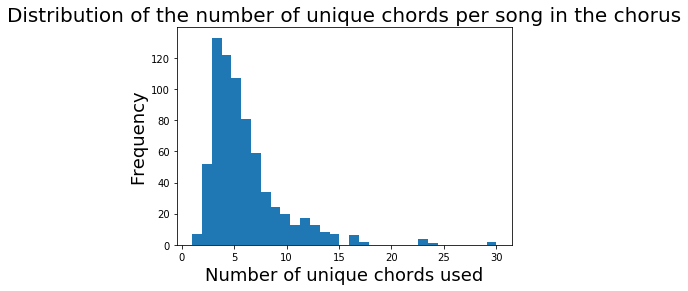

Statistics:
count    712.000000
mean       5.841292
std        3.681991
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       30.000000
Name: chord, dtype: float64


In [45]:
stats_chorus = unique_chords_section(beats_collection_df, 'chorus')

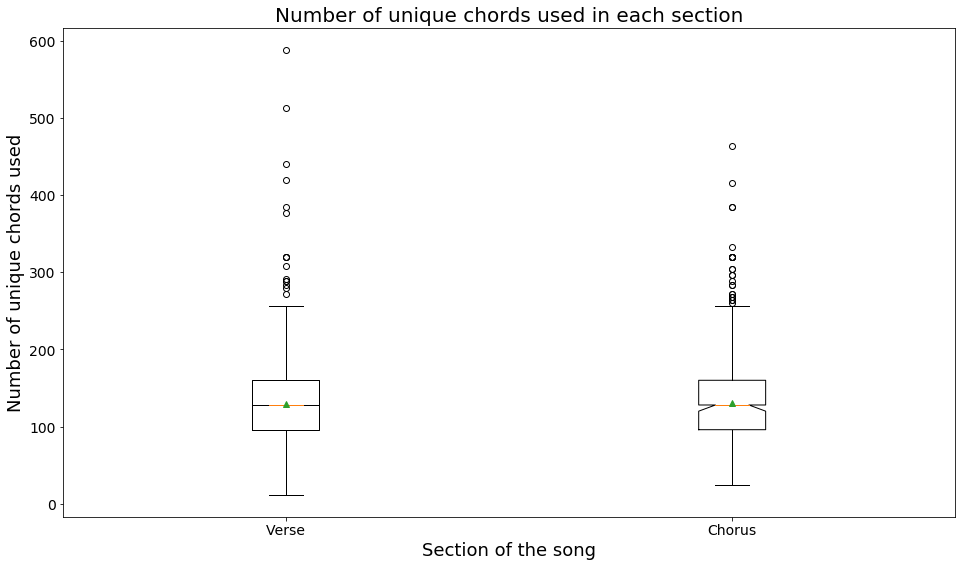

In [46]:
data = [beats_collection_df[beats_collection_df.section_type == 'verse'].groupby('song_id').count().title,
        beats_collection_df[beats_collection_df.section_type == 'chorus'].groupby('song_id').count().title]
plt.figure(figsize = (16,9))
plt.boxplot(data, notch = True, 
                  bootstrap = 5000, 
                  showfliers = True, 
                  showmeans = True)
plt.title('Number of unique chords used in each section', fontsize = 20)
plt.xticks([1,2], ['Verse', 'Chorus'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Section of the song', fontsize = 18)
plt.ylabel('Number of unique chords used', fontsize = 18)
plt.show()

Finally, we'll use statistical tests to find if the differences observed are significant. From the previous plots, we can already expect to not have significant differences here.

In [39]:
from scipy import stats
import researchpy as rp

We will run an independent t-test to check if the two sample data, i.e. the number of unique chords used in the verse and in the chorus sections of the songs, are the same or not. But first we need to check the independent t-test assumptions:
   * homogeneity of variances (with the Levene's test)
   * normal distributions of redisuals (with Shapiro-Wilk's test)

In [48]:
stats.levene(data[0], data[1])

LeveneResult(statistic=0.008818036651116804, pvalue=0.9251983262417289)

In [49]:
stats.shapiro(data[0] - data[1]) #Need to have the same size, ie only keep songs with both a chorus & a verse

(0.9734162092208862, 4.413588938767532e-10)

Since both assumptions are met (both p-values are larger than 0.05, meaning the sample data do not violate the assumptions), we can proceed with the independent t-test. Let's start by having a quick look at some basic statistics (where the first line is for verse, the second for chorus and the third for the combined data). As already seen with the plots, means and SDs are nearly the same.

In [50]:
descriptives, results = rp.ttest(data[0], data[1])
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,title,712.0,129.883427,62.904246,2.357436,125.255058,134.511796
1,title,712.0,130.717697,60.304691,2.260014,126.280598,135.154796
2,combined,1424.0,130.300562,61.597938,1.632342,127.098507,133.502617


In [51]:
results

,Independent t-test,results
0,Difference (title - title) =,-0.8343
1,Degrees of freedom =,1422.0000
2,t =,-0.2555
3,Two side test p value =,0.7984
4,Difference < 0 p value =,0.3992
5,Difference > 0 p value =,0.6008
6,Cohen's d =,-0.0135
7,Hedge's g =,-0.0135
8,Glass's delta =,-0.0133
9,r =,0.0068


As expected, the two sample data do not violate the null hypothesis because p-value=0.8502 > 0.05 (i.e. there are no significant differences).

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> the distribution of the number of unique chords used in each section has ben investigated. For both verse and chorus sections, the distribution is right skewed with a mean slighly under 6 unique chords used and a tail with maximum values reaching up to 30 unique chords used. An independent t-test has been conducted to find if the differences are statistically significant. As expected, results (t[1595]=0.1889, p-value=0.8502 > 0.5) show that the two sample data do not violate the null hypothesis (i.e. the two distributions are similar). 
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Root of the chords</strong>
</div> 

Now we can look at the roots of the chords, first on the whole songs and then on each section.

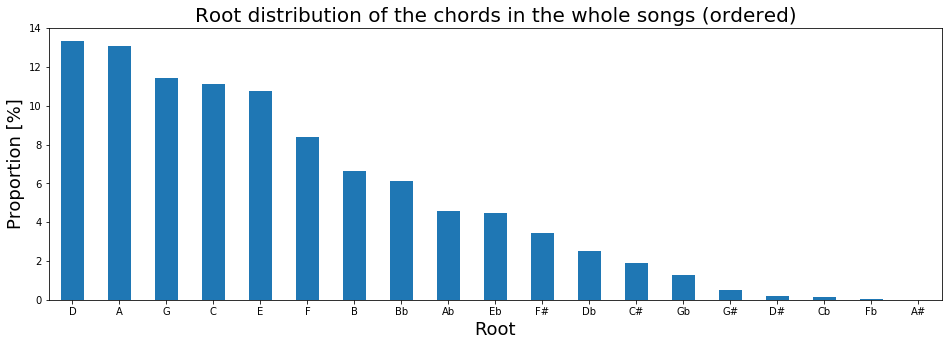

In [52]:
root_dist = beats_collection_df.root.value_counts()
#We remove the missing values (marked with an empty space by our parser)
root_dist.drop('', inplace = True)
#Plot
plt.figure(figsize = (16,5))
root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
plt.title('Root distribution of the chords in the whole songs (ordered)', fontsize = 20)
plt.xlabel('Root', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

We can also move to the line of fifths representation to check if we get the characteristic bell shape.

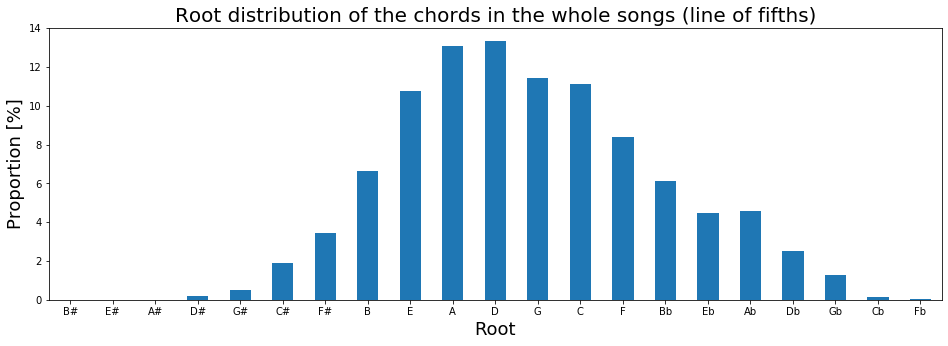

In [53]:
root_dist = beats_collection_df.root.value_counts()
#Let's move to the line of fifths
fifths_line = ['B#', 'E#', 'A#', 'D#', 'G#', 'C#', 'F#', 
               'B', 'E', 'A', 'D', 'G', 'C', 'F', 
               'Bb', 'Eb', 'Ab', 'Db', 'Gb', 'Cb', 'Fb']
root_dist = pd.Series(index = fifths_line, data = root_dist).fillna(0)
#Plot
plt.figure(figsize = (16,5))
root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
plt.title('Root distribution of the chords in the whole songs (line of fifths)', fontsize = 20)
plt.xlabel('Root', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [54]:
def root_distribution_section(df, section = 'verse', root_repr = 'root', index = 1, fifths = True):
    root_dist = df[df.section_type == section][root_repr].value_counts()
    if fifths:
        root_dist = pd.Series(index = fifths_line, data = root_dist).fillna(0)
    else:
        #We remove the non-roots notation elements
        if '' in root_dist.index:
            root_dist.drop('', inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, index)
    root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
    title = 'Root distribution of the chords in the ' + section
    if fifths:
        title += ' (line of fifths)'
    else:
        title += ' (ordered)'
    plt.title(title, fontsize = 20)
    plt.xlabel('Root', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

Let's first plot the results on a normal scale from the most used to the least used roots.

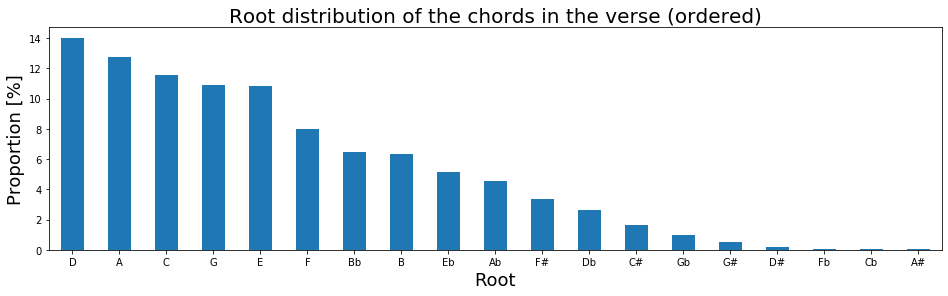

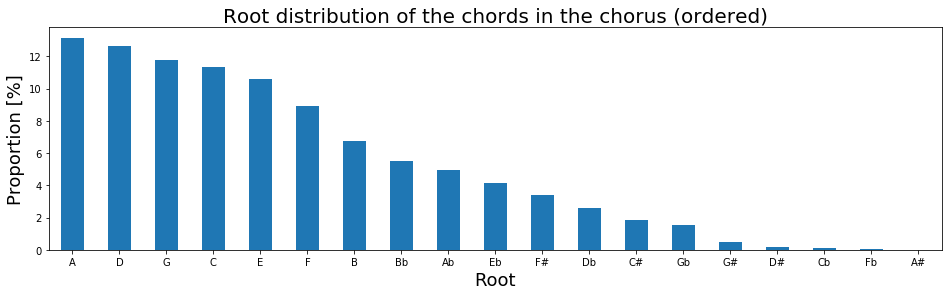

In [55]:
root_distribution_section(beats_collection_df, 'verse', 'root', 1, False)
root_distribution_section(beats_collection_df, 'chorus', 'root', 2, False)

And then using again the line of fifths.

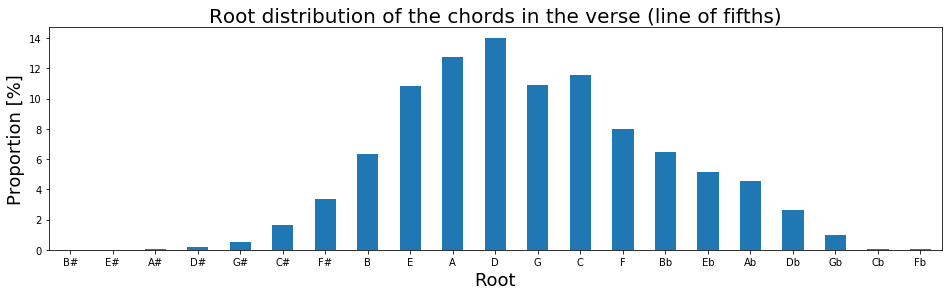

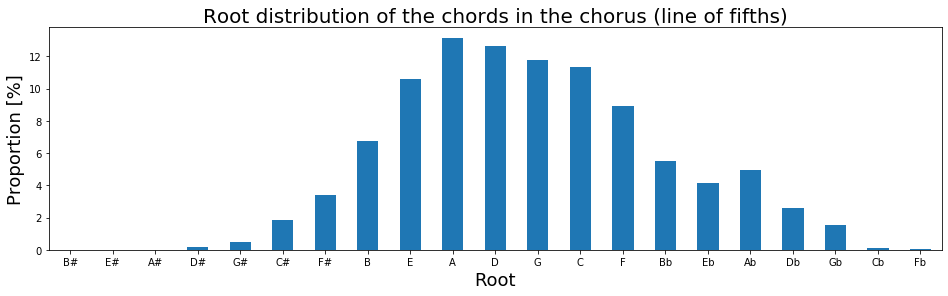

In [56]:
root_distribution_section(beats_collection_df, 'verse', 'root', 1)
root_distribution_section(beats_collection_df, 'chorus', 'root', 2)

Finally, we can also show the relative-to-the-tonic roots distribution.

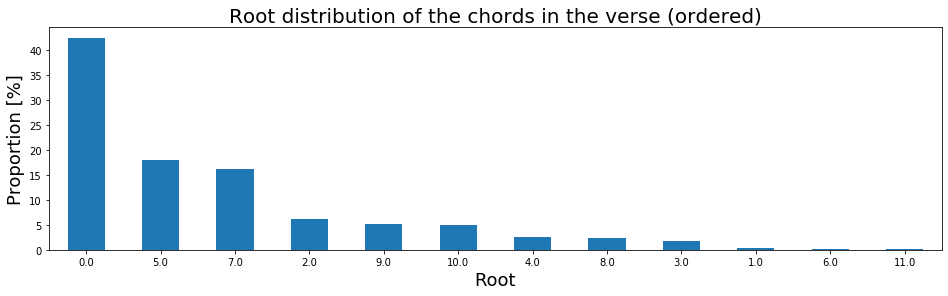

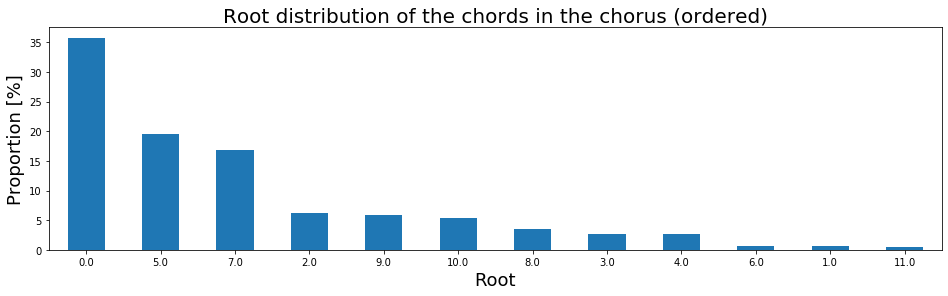

In [57]:
root_distribution_section(beats_collection_df, 'verse', 'relative_root_tpc', 1, False)
root_distribution_section(beats_collection_df, 'chorus', 'relative_root_tpc', 2, False)

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> the distributions of roots (in either versions, relative or not) look fairly similar, with differences in the order of 1%. It is interesting to note that, when using the line of fifths order, we find the characteristic bell-shaped distribution. 
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Quality of the chords</strong>
</div> 

Next we can investigate the quality (or type) of the chords, using the parser previously defined.

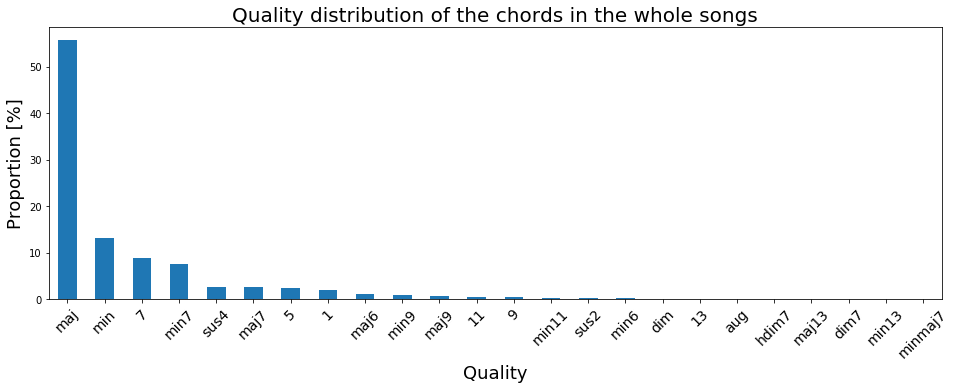

In [58]:
quality_dist = beats_collection_df.shorthand.value_counts()
#We remove the missing values (marked with an empty space by our parser)
quality_dist.drop(['', '*', '&pause'], inplace = True)
#Plot
plt.figure(figsize = (16,5))
quality_dist.map(lambda x: 100 * x / quality_dist.sum()).plot(kind = 'bar')
plt.title('Quality distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Quality', fontsize = 18)
plt.xticks(rotation = 45, fontsize = 14)
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [59]:
def quality_distribution_section(df, section = 'verse'):
    quality_dist = df[df.section_type == section].shorthand.value_counts()
    #We remove the non-roots notation elements
    extra_notations = ['', '*', '&pause']
    for notation in extra_notations:
        if notation in quality_dist.index:
            quality_dist.drop(notation, inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, 1)
    quality_dist.map(lambda x: 100 * x / quality_dist.sum()).plot(kind = 'bar')
    title = 'Quality distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Quality', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 14)
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

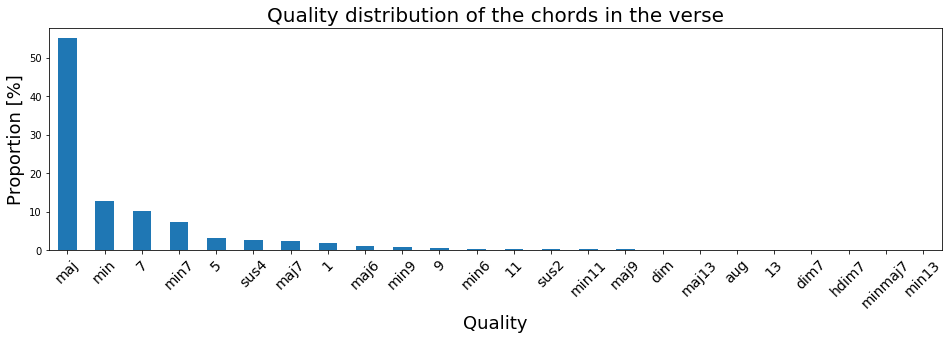

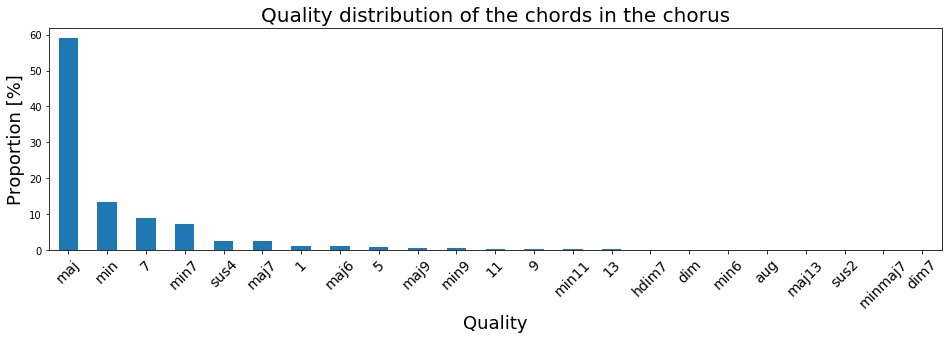

In [60]:
quality_distribution_section(beats_collection_df, 'verse')
quality_distribution_section(beats_collection_df, 'chorus')

We observe that major chords are the most used by a large margin. Then come in a close range minor, seventh and minor seventh chords. All other chords have much lower frequencies of usage in both verse and chorus sections. Let's compare the mean proportion of these four predominants chord qualities between the two sections.

In [61]:
def GetCountsOfQuality(df, section, quality):
    return df[df.section_type == section][df.shorthand == quality].groupby('song_id').count().title

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



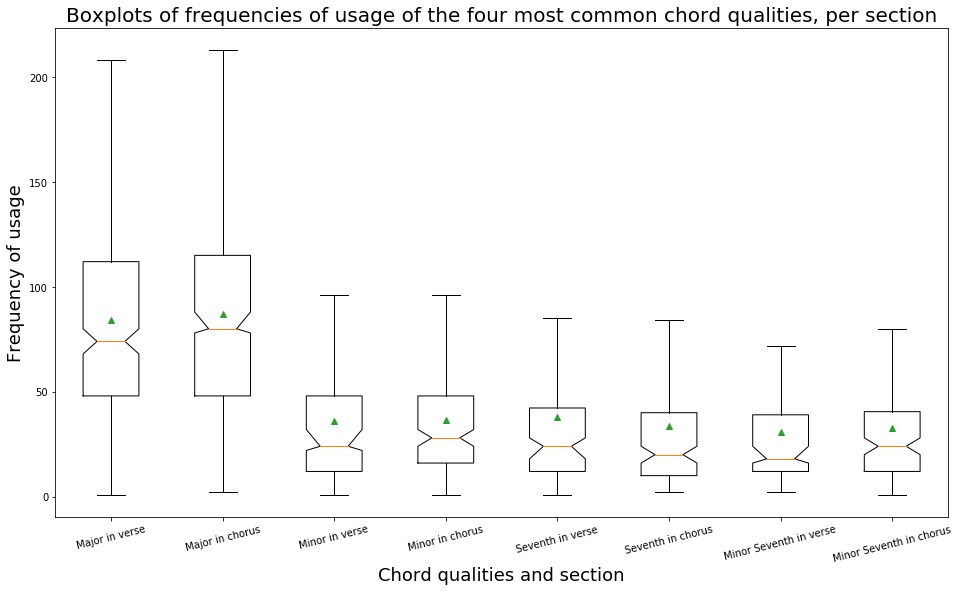

In [62]:
labels = ['Major in verse', 'Major in chorus',
          'Minor in verse', 'Minor in chorus',
          'Seventh in verse', 'Seventh in chorus',
          'Minor Seventh in verse', 'Minor Seventh in chorus']
data = [GetCountsOfQuality(beats_collection_df, 'verse', 'maj'), 
        GetCountsOfQuality(beats_collection_df, 'chorus', 'maj'),
        GetCountsOfQuality(beats_collection_df, 'verse', 'min'),
        GetCountsOfQuality(beats_collection_df, 'chorus', 'min'),
        GetCountsOfQuality(beats_collection_df, 'verse', '7'),
        GetCountsOfQuality(beats_collection_df, 'chorus', '7'),
        GetCountsOfQuality(beats_collection_df, 'verse', 'min7'),
        GetCountsOfQuality(beats_collection_df, 'chorus', 'min7')]
plt.figure(figsize = (16, 9))
plt.boxplot(data,
            notch = True,
            bootstrap = 5000,
            showfliers = False, #Don't show outliers to better compare medians between the two sections
            showmeans = True)
plt.xticks(range(1,9), labels, rotation = 14)
plt.title('Boxplots of frequencies of usage of the four most common chord qualities, per section', fontsize = 20)
plt.xlabel('Chord qualities and section', fontsize = 18)
plt.ylabel('Frequency of usage', fontsize = 18)
plt.show()

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> the most striking result is certainly the overwhelming presence of major chords in the corpus, representing more than half of all the chords (followed by minor chords around 15%). However the differences between verse and chorus chords are fairly small again. We plot the four most common chord qualities (major, minor, seventh and minor seventh), representing more than 80% of our corpus, using boxplots to better compare between the two sections. According to the notches on the boxplots, some differences might indeed be statistically significant but further statistical tests would be needed to verity that.
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Bass note of the chords</strong>
</div> 

Finally, the third element of a chord that we can observe is the bass note used (or the lack of it, in most cases).

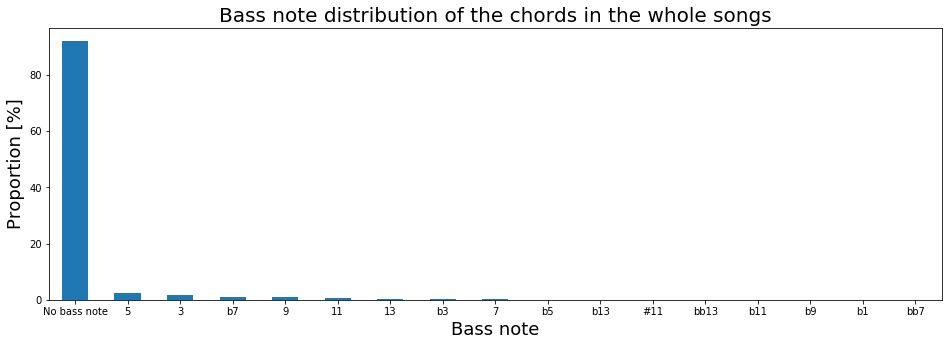

In [63]:
bass_note_dist = beats_collection_df.bass.value_counts().rename({'':'No bass note'})
#Plot
plt.figure(figsize = (16,5))
bass_note_dist.map(lambda x: 100 * x / bass_note_dist.sum()).plot(kind = 'bar')
plt.title('Bass note distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Bass note', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

As we can see, most chords do not use a bass note. We will therefore exclude this case in order to better observe which notes are more commonly used as bass notes.

In [64]:
def bassnote_distribution_section(df, section = 'verse'):
    bass_note_dist = df[df.section_type == section].bass.value_counts()
    #We remove the non-roots notation elements
    if '' in bass_note_dist.index:
        bass_note_dist.drop('', inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, 1)
    bass_note_dist.map(lambda x: 100 * x / bass_note_dist.sum()).plot(kind = 'bar')
    title = 'Bass note distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Bass note', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

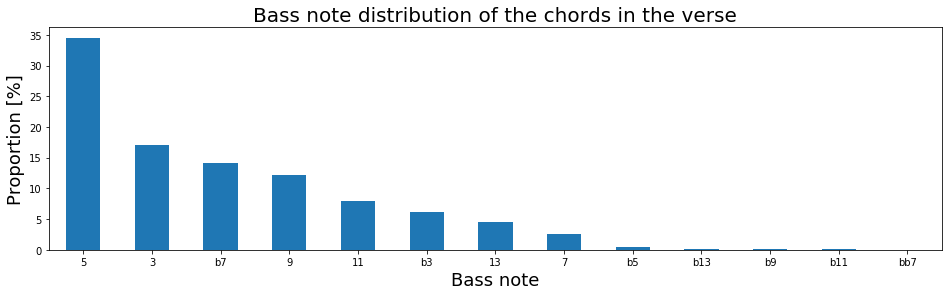

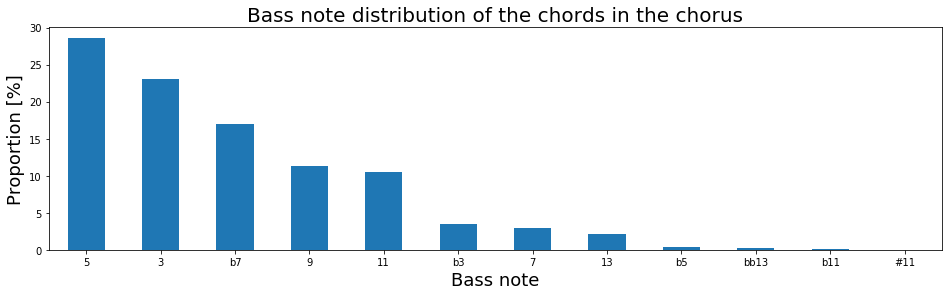

In [65]:
bassnote_distribution_section(beats_collection_df, 'verse')
bassnote_distribution_section(beats_collection_df, 'chorus')

As we did for chord qualities, we will investigate more in depth the frequencies of usage of the most common bass notes, in this case note 5 and note 3.

In [66]:
def GetCountsOfBassNote(df, section, bass_note):
    return df[df.section_type == section][df.bass == bass_note].groupby('song_id').count().title

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



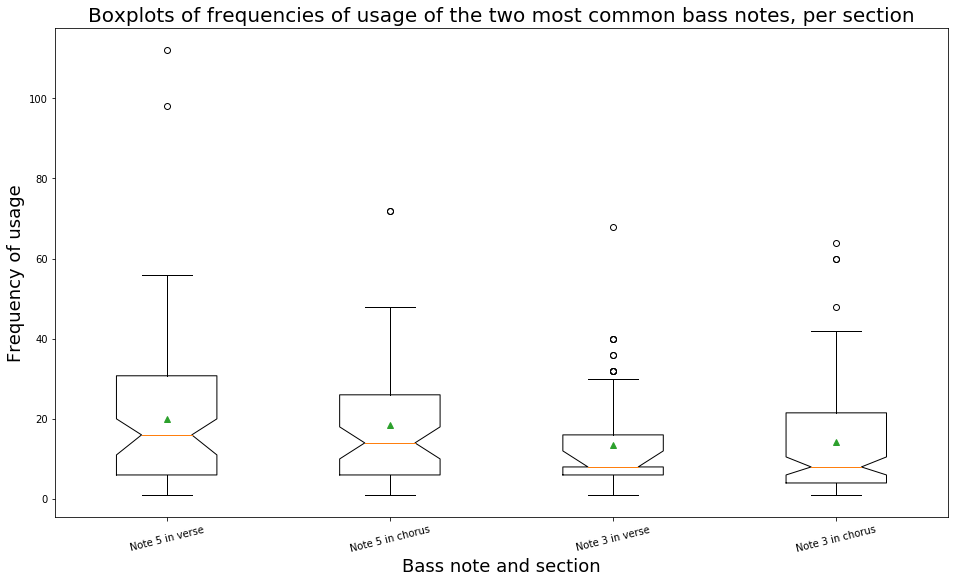

In [67]:
labels = ['Note 5 in verse', 'Note 5 in chorus',
          'Note 3 in verse', 'Note 3 in chorus']
data = [GetCountsOfBassNote(beats_collection_df, 'verse', '5'), 
        GetCountsOfBassNote(beats_collection_df, 'chorus', '5'),
        GetCountsOfBassNote(beats_collection_df, 'verse', '3'),
        GetCountsOfBassNote(beats_collection_df, 'chorus', '3')]
plt.figure(figsize = (16, 9))
plt.boxplot(data,
            notch = True,
            bootstrap = 5000,
            showfliers = True, #Here the outliers do not skew too much the boxplots
            showmeans = True)
plt.xticks(range(1,5), labels, rotation = 14)
plt.title('Boxplots of frequencies of usage of the two most common bass notes, per section', fontsize = 20)
plt.xlabel('Bass note and section', fontsize = 18)
plt.ylabel('Frequency of usage', fontsize = 18)
plt.show()

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> As expected, most chords simply do not have a bass note. It seems this is more of an exception. Here, there seem to be some differences between the verse and the chorus, and again we use boxplots to better investigate the two most common bass notes used (notes 5 and 3). According to the notches, the differences don't seem significant but further tests can here again be used to assessed that.
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>BoW representation</strong>
</div> 

Here we try to move to a more advanced analysis, trying to analyze and compare songs and sections of songs as a whole. Let's start by creating a function to compute the Bag of Words representation of each song (or part of a song). In this case, the words will be all the possible chords (either in absolute or relative to the tonic tpc).

In [41]:
vocab = dict.fromkeys(beats_collection_df.chord.unique(), 0) 
vocab_relative = dict.fromkeys(beats_collection_df.relative_chord.unique(), 0) 

Let's remove the non-chords elements.

In [42]:
for non_chord in ['', '&pause', 'nan', 'nan*']:
    vocab.pop(non_chord, None)
    vocab_relative.pop(non_chord, None)

In [43]:
def createBOW(chord_list, vocab = vocab):
    bow = vocab
    for chord in chord_list:
        if chord in bow.keys():
            bow[chord] += 1
    #Normalise the BoW to get a distribution
    total = sum(bow.values())
    bow = {chord: count/total for chord, count in bow.items()}
    return bow

We can then start to compute the BoW representation of the whole songs, using the function squeeze() previously created to help us.

In [44]:
def createBOW_df(df, vocab = vocab, chord = 'chord'):
    df_squeezed = squeeze(df)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.song_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['song_id'] = df_squeezed.song_id.unique()    
    
    return data[["song_id"] + list(vocab.keys())]

In [45]:
def createBOW_df_section(df, section, vocab = vocab, chord = 'chord'):
    df_squeezed = squeeze(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.song_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['song_id'] = df_squeezed.song_id.unique()    
    
    return data[["song_id"] + list(vocab.keys())]

In [46]:
def createBOW_df_individual_sequence(df, section, vocab = vocab, chord = 'chord'):
    df_squeezed = squeeze_section(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.sequence_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['sequence_id'] = df_squeezed.sequence_id    
    
    return data[["sequence_id"] + list(vocab.keys())]

First, we create the bow representation of whole songs or all chords corresponding to the given section, in absolute tpc.

In [47]:
df_bow = createBOW_df(beats_collection_df)
df_bow_verse = createBOW_df_section(beats_collection_df, 'verse')
df_bow_chorus = createBOW_df_section(beats_collection_df, 'chorus')

In [48]:
df_bow.head()

,song_id,Ab:maj,Db:maj/5,G:hdim7,C:7,F:min,C:7/5,F:min/b3,Bb:min7,Eb:7,...,Db:7/b7,D:min7/b7,Ab:1(b7),Db:1(b7),Gb:1(b7),Ab:min(11),Gb:min,Db:5(b7),A:sus4(9),Ab:maj7/9
0,4,0.295775,0.098592,0.021127,0.028169,0.042254,0.028169,0.007042,0.070423,0.070423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.100000,0.033333,0.007143,0.009524,0.014286,0.009524,0.002381,0.023810,0.023810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12,0.065934,0.021978,0.004710,0.006279,0.009419,0.006279,0.001570,0.015699,0.015699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,0.047032,0.015677,0.003359,0.004479,0.006719,0.004479,0.001120,0.011198,0.011198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,0.044366,0.012422,0.002662,0.003549,0.021295,0.003549,0.000887,0.008873,0.008873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then the same in relative to the tonic tpc.

In [49]:
df_bow_rel = createBOW_df(beats_collection_df, vocab_relative, 'relative_chord')
df_bow_verse_rel = createBOW_df_section(beats_collection_df, 'verse', vocab_relative, "relative_chord")
df_bow_chorus_rel = createBOW_df_section(beats_collection_df, 'chorus', vocab_relative, "relative_chord")

And finally we create the bow representation for individual sections (meaning a song with two verses will give two distict verse sections). Here as well we use the relative to the tonic tpc.

In [50]:
df_bow_chorus_rel_seq = createBOW_df_individual_sequence(beats_collection_df, 'chorus', vocab_relative, 'relative_chord')
df_bow_verse_rel_seq = createBOW_df_individual_sequence(beats_collection_df, 'verse', vocab_relative, 'relative_chord')

### Considerations on whether to consider each section individually or grouped together by song

In [51]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

In [52]:
df_bow_chorus_rel_seq['song_id'] = df_bow_chorus_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))
df_bow_verse_rel_seq['song_id'] = df_bow_verse_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))

In [211]:
def ComputeDifferences1(df1, df2, features, section):
    diff = (df1.groupby('song_id').mean().reset_index()[features] - df2[features]).mean()
    plt.figure(figsize = (14,5))
    diff.plot(kind = 'hist', bins = 100, fontsize = 14)
    title = 'Distribution of the differences between the mean BoW of each section of a song and the BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Difference', fontsize = 18)
    plt.ylabel('Number of songs', fontsize = 18)
    plt.show()
    
    print(rp.summary_cont(diff))

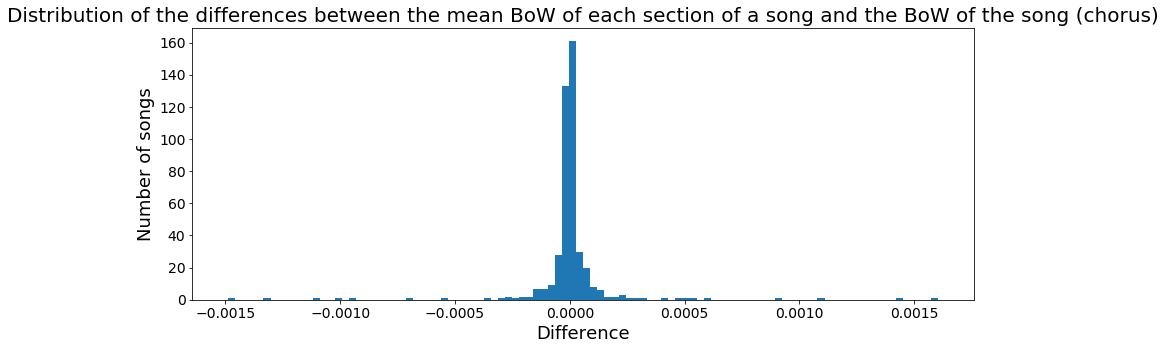



   Variable      N          Mean      SD        SE  95% Conf.  Interval
0       NaN  444.0 -3.418655e-21  0.0002  0.000009  -0.000019  0.000019


In [212]:
ComputeDifferences1(df_bow_chorus_rel_seq, df_bow_chorus_rel, vocab_relative.keys(), 'chorus')

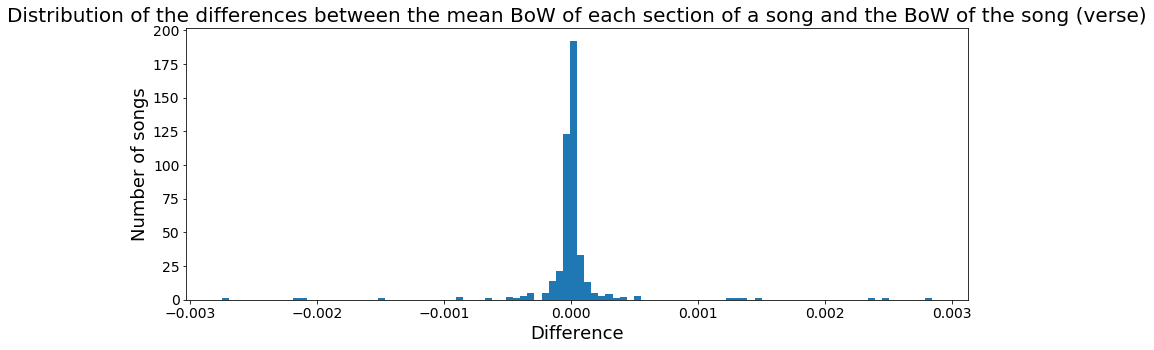



   Variable      N          Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -3.662845e-22  0.000345  0.000016  -0.000032  0.000032


In [213]:
ComputeDifferences1(df_bow_verse_rel_seq, df_bow_verse_rel, vocab_relative.keys(), 'verse')

In [248]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

In [270]:
def ComputeDifferences2(df1, df2, features, section):
    diff = []
    for seq_id in df1.sequence_id.unique():
        diff.append(cosine(df1[df1.sequence_id == seq_id][features].squeeze(), df2[df2.song_id == int(seq_id.split(':')[0])][features].squeeze()))
    plt.figure(figsize = (14,5))
    plt.hist(diff, bins = 100)
    title = 'Distribution of the cosine distances between the BoW of each section of a song and the full BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Difference', fontsize = 18)
    plt.ylabel('Number of songs', fontsize = 18)
    plt.show()
    
    print(rp.summary_cont(pd.Series(diff)))

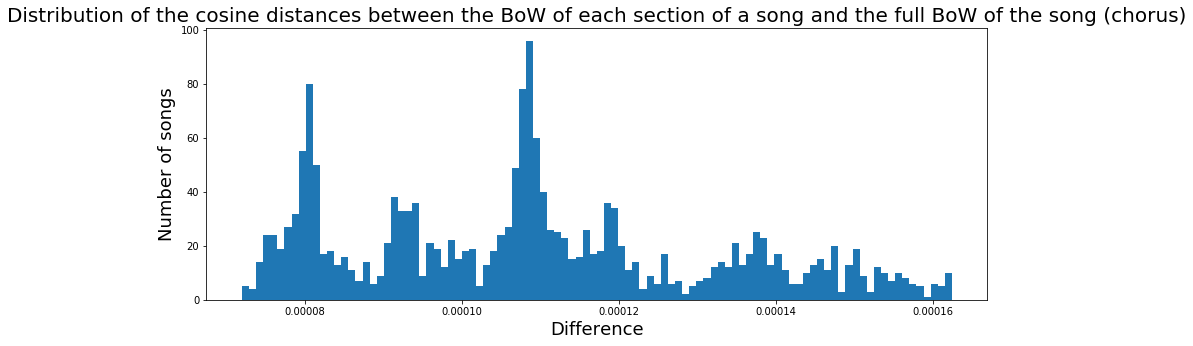



   Variable       N      Mean        SD            SE  95% Conf.  Interval
0       NaN  1889.0  0.000109  0.000023  5.255891e-07   0.000108   0.00011


In [272]:
ComputeDifferences2(df_bow_chorus_rel_seq, df_bow_chorus_rel, vocab_relative.keys(), 'chorus')

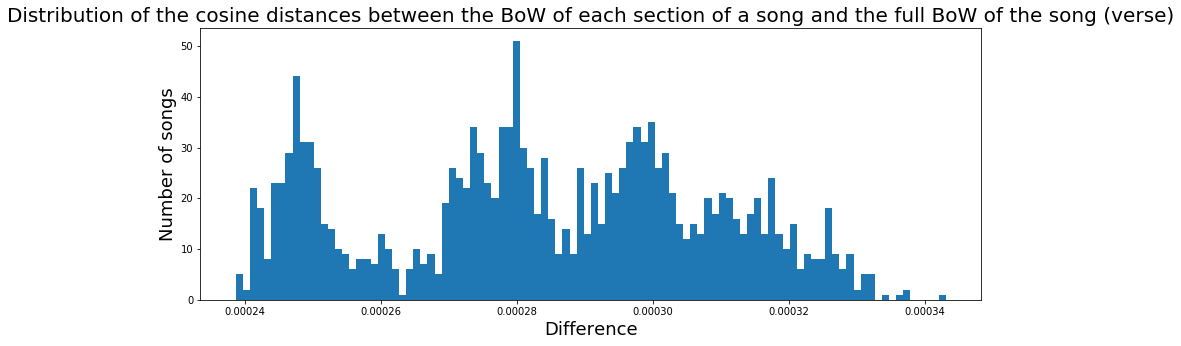



   Variable       N      Mean        SD            SE  95% Conf.  Interval
0       NaN  1591.0  0.000284  0.000024  6.123502e-07   0.000283  0.000285


In [271]:
ComputeDifferences2(df_bow_verse_rel_seq, df_bow_verse_rel, vocab_relative.keys(), 'verse')

## Dimensionality reduction on the verses and the choruses

### PCA

In [59]:
from sklearn.decomposition import PCA

In [60]:
def PlotTopChordByWeight(pca_model, pc, features, n_weights = 10):
    pc_id = pc - 1
    top_positive_weights = pd.DataFrame(columns = features, data = pca_model.components_)\
                                                .iloc[pc_id].sort_values(ascending = False)[:n_weights]
    top_negative_weights = pd.DataFrame(columns = features, data = pca_model.components_)\
                                                .iloc[pc_id].sort_values(ascending = True)[:n_weights].sort_values(ascending = False)
    plt.figure(figsize = (14,6))
    plt.bar(x = range(n_weights), height = top_positive_weights)
    plt.bar(x = range(-n_weights, 0), height = top_negative_weights)
    plt.xticks(range(-n_weights, n_weights), top_negative_weights.index.append(top_positive_weights.index), rotation = 30)
    title = 'Importance of each chord for PC' + str(pc) + ' (top ' + str(n_weights) + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Chord', fontsize = 18)
    plt.ylabel('Weight of the chord', fontsize = 18)
    plt.grid(True, alpha = 0.5)
    plt.show()

In [351]:
def PCA_visualization(df1, df2, vocab = vocab, n_comps = 12, n_weights = 10, prop_variance = 0.95):
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df1.loc[:, features].values, df2.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df1)), np.ones(len(df2))))
    pca = PCA(n_components = n_comps, svd_solver = "full", random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = (8,8))
    plt.scatter(principalDf[principalDf.label == 0]['PC1'], 
                principalDf[principalDf.label == 0]['PC2'], 
                c = 'red', 
                alpha = 0.1,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['PC1'], 
                principalDf[principalDf.label == 1]['PC2'], 
                c = 'blue', 
                alpha = 0.1,
                label = 'Chorus')
    plt.title('PCA with 2 components on the verses and choruses', fontsize = 20)
    plt.xlabel('PC1', fontsize = 18)
    plt.ylabel('PC2', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.show()
    
    print('The first 2 components explain respectively %0.2f%% and %0.2f%% of the variance,' %(100 * pca.explained_variance_ratio_[0],
                                                                                     100 * pca.explained_variance_ratio_[1]))
    print('for a total of %0.2f%% of the total variance.' % (100 * (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])))
    
    #Plot the top weights
    PlotTopChordByWeight(pca, 1, features, n_weights) #PC1
    PlotTopChordByWeight(pca, 2, features, n_weights) #PC2
    
    #Print the minimum number of PCs needed to preserve the given amount of variance
    pca = PCA(prop_variance)
    pca.fit(X)
    print('The mininum number of PCs to explain %0.2f%% of the variance is %d.' % (100 * prop_variance, pca.n_components_))
    
    return principalDf

In [62]:
def PC_differences(principalDf, relative = False):  
    #Computation of the PC differences
    n_songs = int(len(principalDf)/2)
    diff_PC_same_song = (principalDf[:n_songs].values - principalDf[n_songs:].values)
    diff_PC_same_song = pd.DataFrame(columns = ['Diff_PC1', 'Diff_PC2'], data = diff_PC_same_song[:,:2], index = range(n_songs))
    diff_PC_same_song['Diff_PC1'] = diff_PC_same_song['Diff_PC1'].map(lambda x: 100 * x / diff_PC_same_song['Diff_PC1'].max())
    diff_PC_same_song['Diff_PC2'] = diff_PC_same_song['Diff_PC2'].map(lambda x: 100 * x / diff_PC_same_song['Diff_PC2'].max())

    #Plot of the PC differences
    plt.figure(figsize = (14,6))
    plt.scatter(x = range(n_songs), y = diff_PC_same_song['Diff_PC1'].values, c = 'red', label = 'Difference PC1')
    plt.scatter(x = range(n_songs), y = diff_PC_same_song['Diff_PC2'].values, c = 'blue', label = 'Difference PC2')
    title = "PC differences between verses and choruses of the same song"
    legend_loc = "lower right"
    if relative:
        title += " (relative tpc)"
        legend_loc = "lower left"
    plt.legend(fontsize = 18, loc = legend_loc)
    plt.title(title, fontsize = 20)
    plt.xlabel("Song", fontsize = 18)
    plt.ylabel("PC difference normalized [%]", fontsize = 18)
    plt.show()

#### Absolute tpc

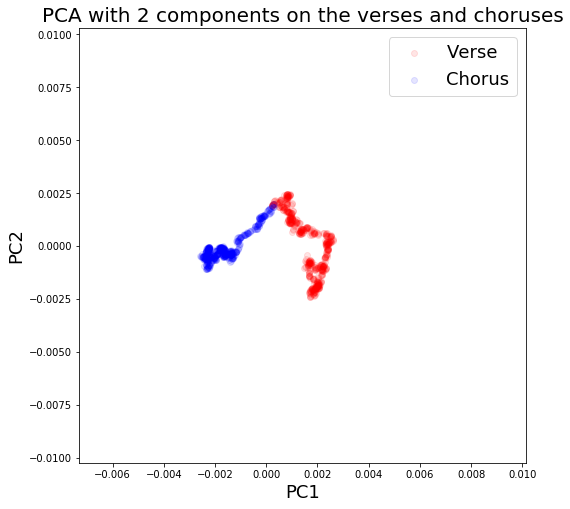

The first 2 components explain respectively 44.56% and 18.90% of the variance,
for a total of 63.46% of the total variance.


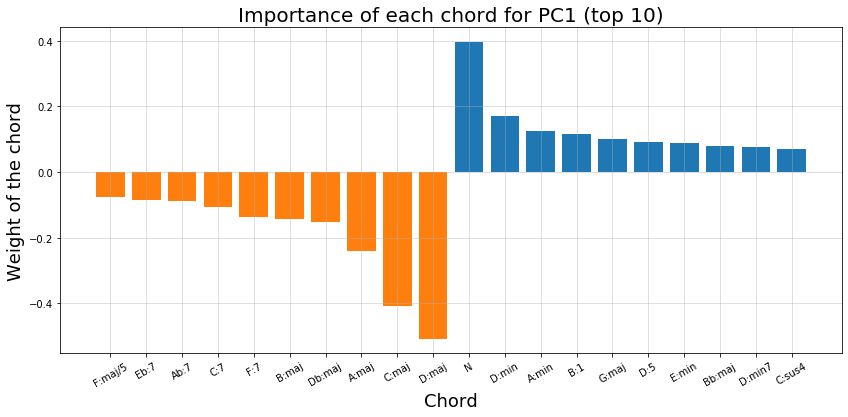

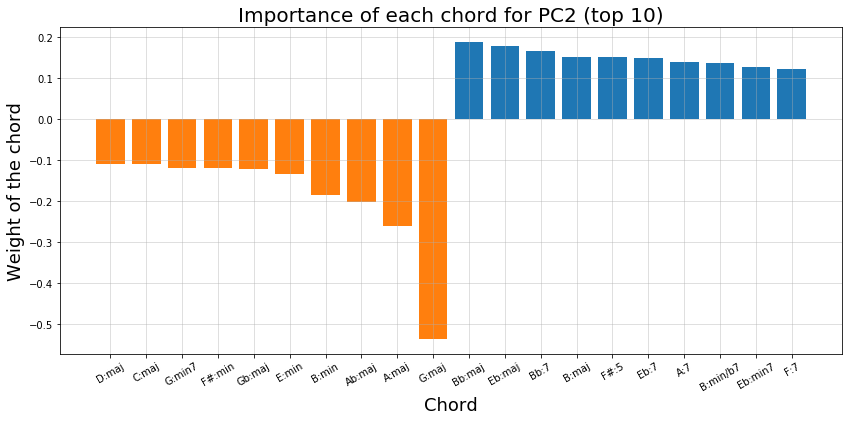

The mininum number of PCs to explain 95.00% of the variance is 13.


In [353]:
principalDf = PCA_visualization(df_bow_verse, df_bow_chorus)

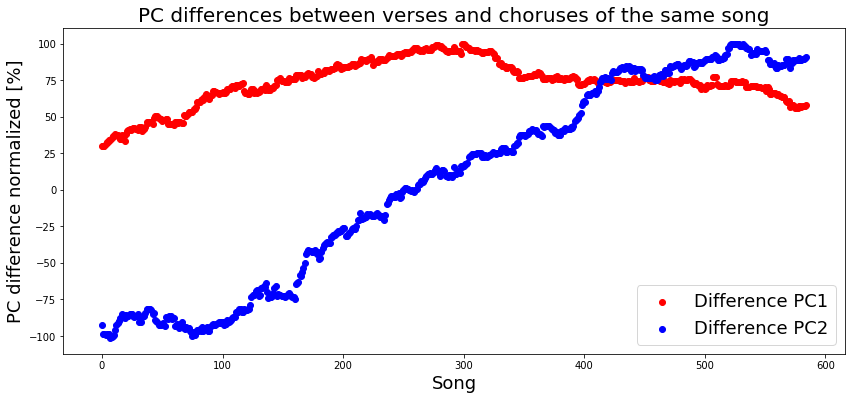

In [64]:
PC_differences(principalDf)

#### Relative tpc

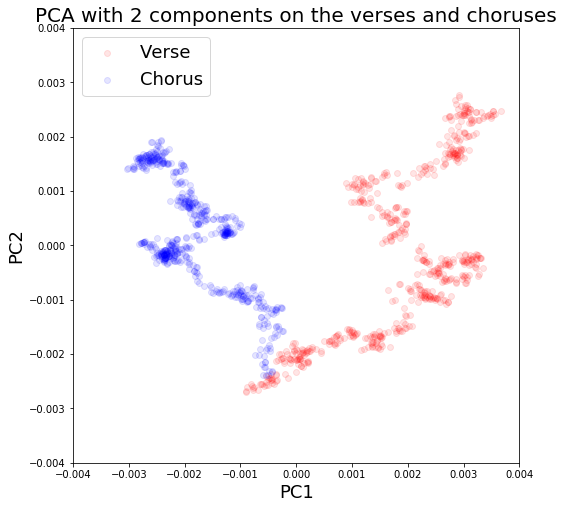

The first 2 components explain respectively 53.97% and 22.10% of the variance,
for a total of 76.07% of the total variance.


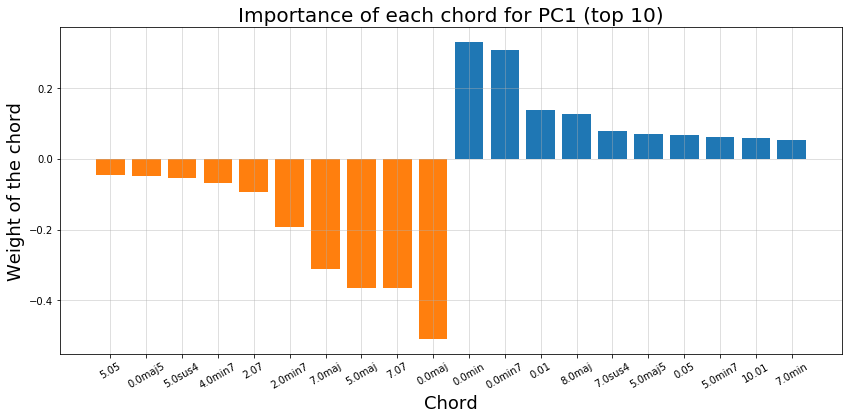

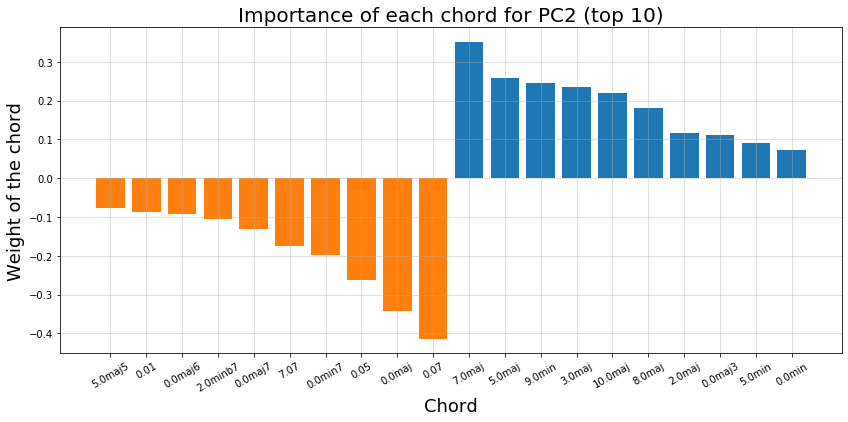

The mininum number of PCs to explain 95.00% of the variance is 8.


In [65]:
principalDf_rel = PCA_visualization(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative, 2)

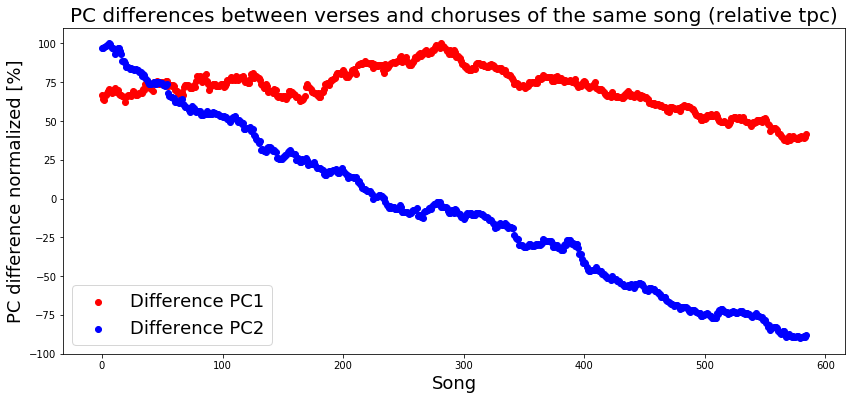

In [66]:
PC_differences(principalDf_rel, True)

In [67]:
principalDf_verse = principalDf[principalDf.label == 0]
principalDf_chorus = principalDf[principalDf.label == 1].reset_index()
principalDf_verse['song_id'] = df_bow_verse.song_id
principalDf_chorus['song_id'] = df_bow_chorus.song_id
principalDf_verse = principalDf_verse.merge(beats_collection_df[['song_id', 'title', 'artist']], on = 'song_id', how = 'outer').drop_duplicates().reset_index()
principalDf_chorus = principalDf_chorus.merge(beats_collection_df[['song_id', 'title', 'artist']], on = 'song_id', how = 'outer').drop_duplicates().reset_index()

In [68]:
max_pc1_songs = principalDf_chorus.sort_values(by = 'PC1', ascending = False)[:5]
min_pc1_songs = principalDf_verse.sort_values(by = 'PC1', ascending = True)[:5]

In [69]:
max_pc1_songs

,level_0,index,PC1,PC2,label,song_id,title,artist
0,0,585,0.000291,0.001999,1.0,4,You've got a Friend,Roberta Flack and Donny Hathaway
3,1274,588,0.000285,0.001858,1.0,16,She Bop,Cyndi Lauper
1,284,586,0.000272,0.001990,1.0,10,An Innocent Man,Billy Joel
4,1786,589,0.000265,0.001859,1.0,18,Kiss On My List,Hall & Oates
5,2254,590,0.000259,0.001851,1.0,19,Here's Some Love,Tanya Tucker


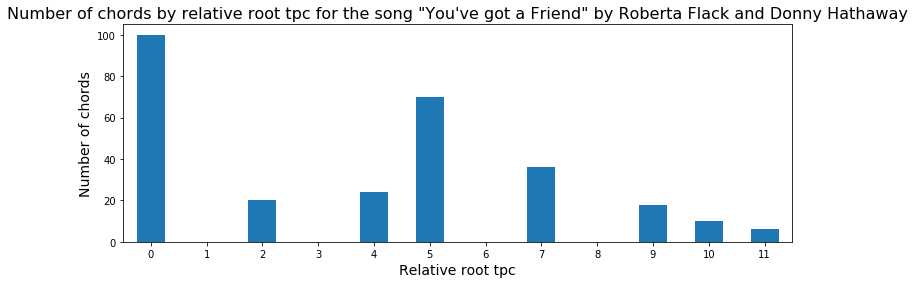

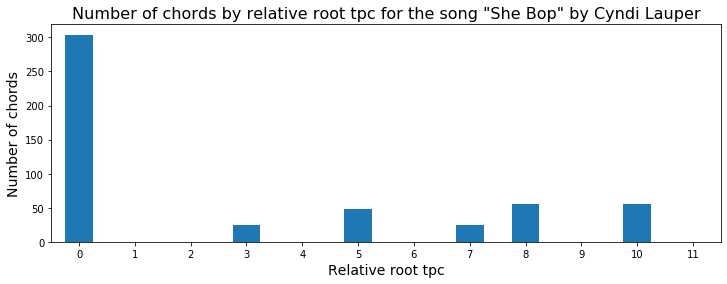

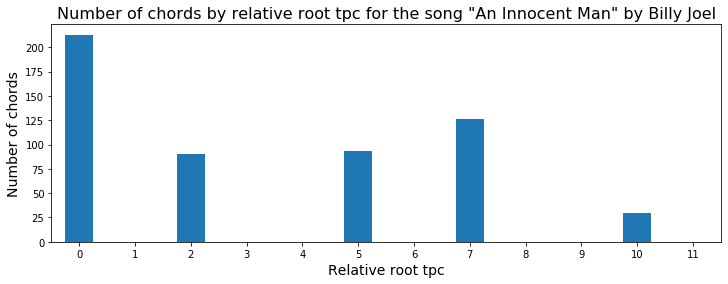

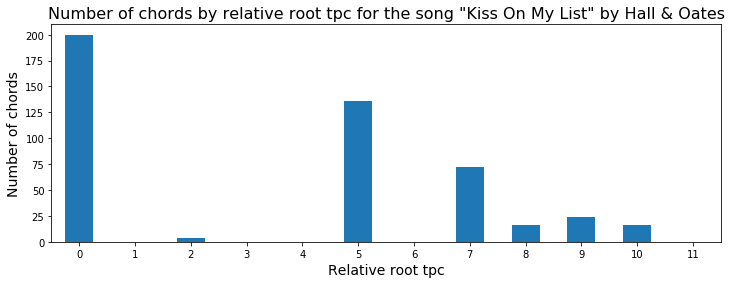

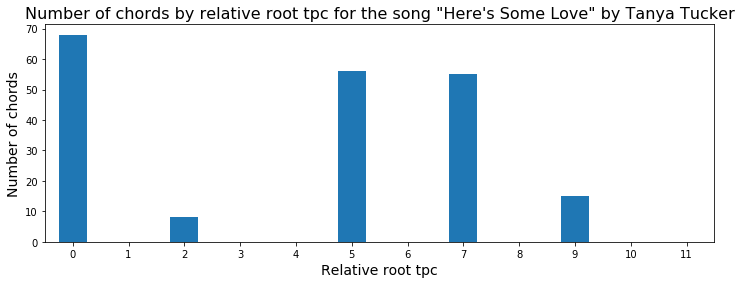

In [70]:
for song_id in max_pc1_songs.song_id:
    data = pd.Series(index = range(12), data = beats_collection_df[beats_collection_df.song_id == song_id].relative_root_tpc.value_counts()).fillna(0)
    plt.figure(figsize = (12,4))
    data.plot(kind = 'bar')
    plt.xticks(rotation = 'horizontal')
    plt.xlabel('Relative root tpc', fontsize = 14)
    plt.ylabel('Number of chords', fontsize = 14)
    song_name = max_pc1_songs[max_pc1_songs.song_id == song_id].title.values[0]
    song_artist = max_pc1_songs[max_pc1_songs.song_id == song_id].artist.values[0]
    title = 'Number of chords by relative root tpc for the song "' + str(song_name) + '" by ' + str(song_artist)
    plt.title(title, fontsize = 16)
    plt.show()

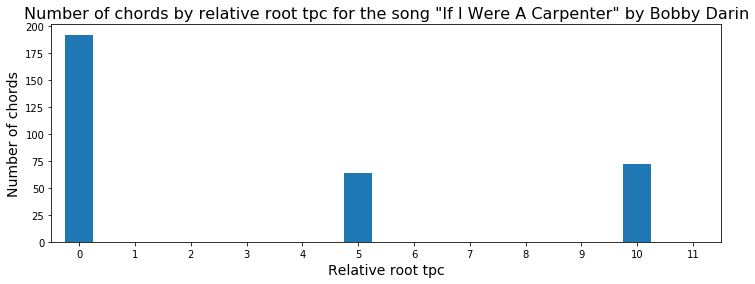

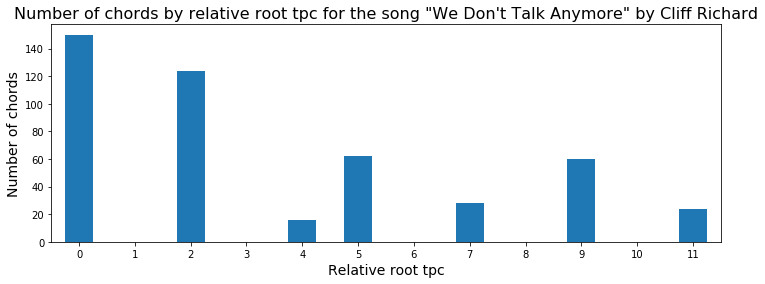

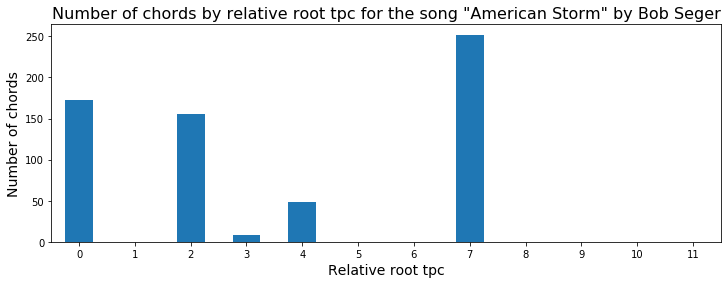

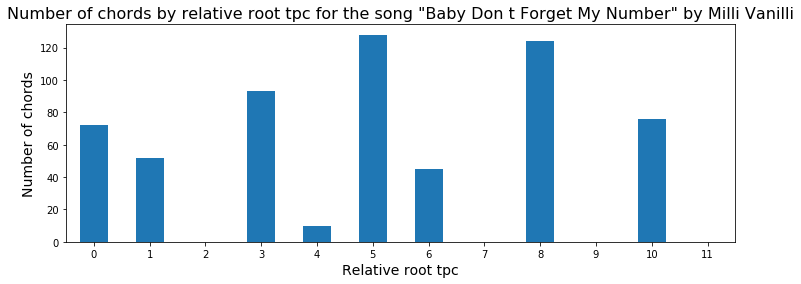

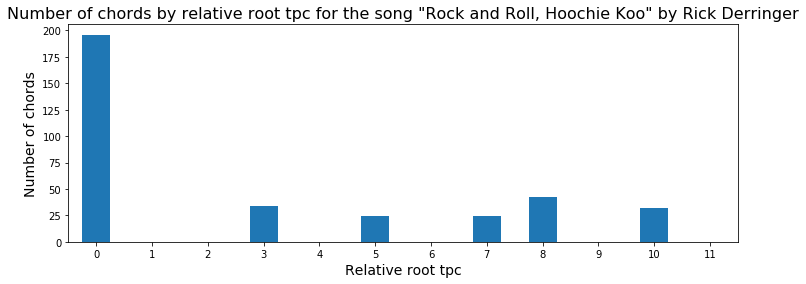

In [71]:
for song_id in min_pc1_songs.song_id:
    data = pd.Series(index = range(12), data = beats_collection_df[beats_collection_df.song_id == song_id].relative_root_tpc.value_counts()).fillna(0)
    plt.figure(figsize = (12,4))
    data.plot(kind = 'bar')
    plt.xticks(rotation = 'horizontal')
    plt.xlabel('Relative root tpc', fontsize = 14)
    plt.ylabel('Number of chords', fontsize = 14)
    song_name = min_pc1_songs[min_pc1_songs.song_id == song_id].title.values[0]
    song_artist = min_pc1_songs[min_pc1_songs.song_id == song_id].artist.values[0]
    title = 'Number of chords by relative root tpc for the song "' + str(song_name) + '" by ' + str(song_artist)
    plt.title(title, fontsize = 16)
    plt.show()

#### Relative tpc and individual sequences

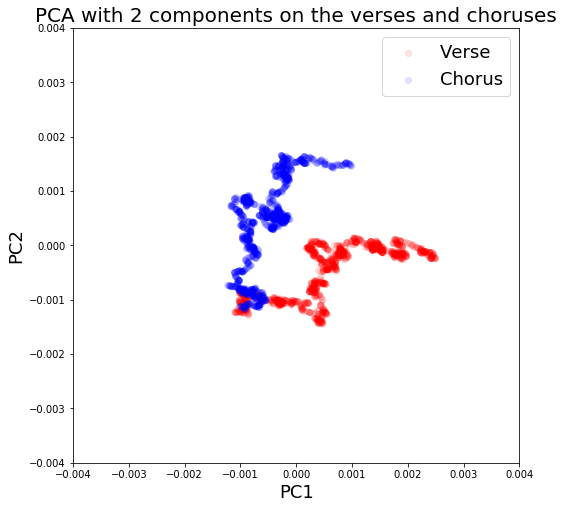

The first 2 components explain respectively 34.57% and 27.69% of the variance,
for a total of 62.26% of the total variance.


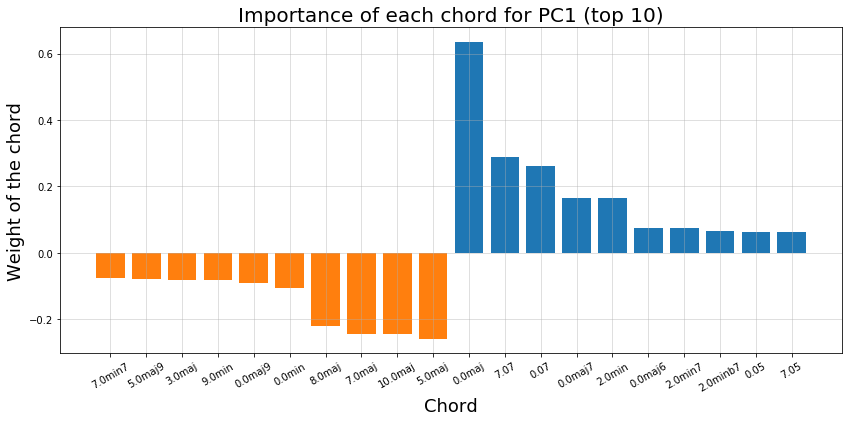

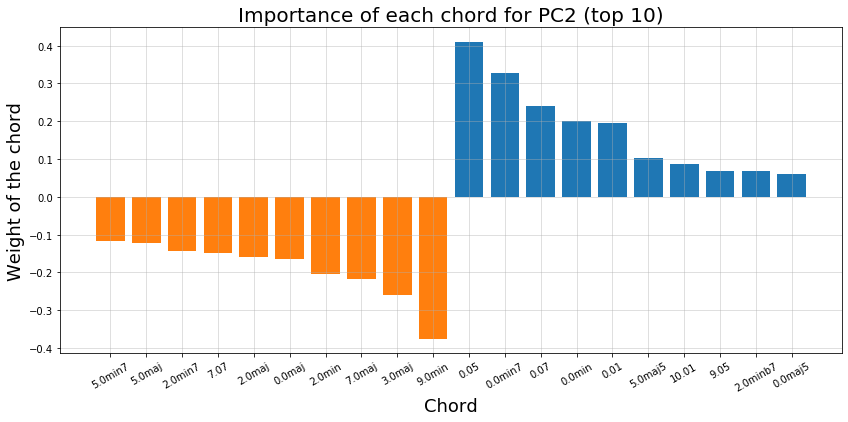

The mininum number of PCs to explain 95.00% of the variance is 10.


In [72]:
principalDf_rel_seq = PCA_visualization(df_bow_verse_rel_seq, df_bow_chorus_rel_seq, vocab_relative)

#### 3D PCA (3 PCs)

In [73]:
from mpl_toolkits.mplot3d import Axes3D

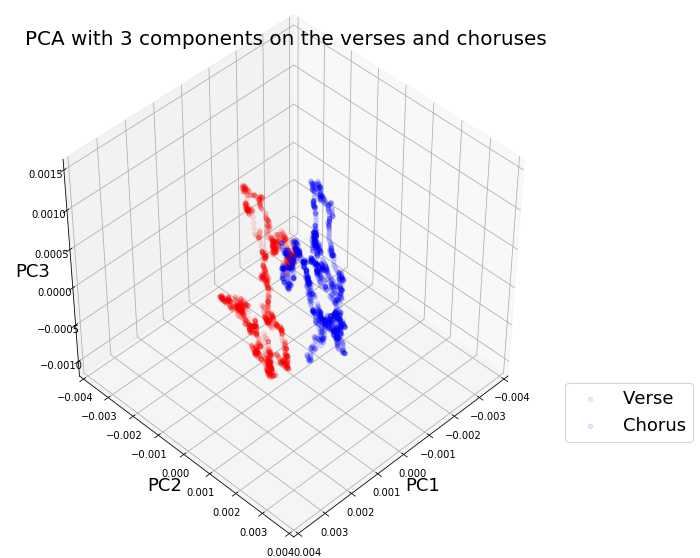

In [118]:
#Train the pca model
features = vocab_relative.keys()
X = np.concatenate((df_bow_verse_rel_seq.loc[:, features].values, df_bow_chorus_rel_seq.loc[:, features].values))
y = np.concatenate((np.zeros(len(df_bow_verse_rel_seq)), np.ones(len(df_bow_chorus_rel_seq))))
pca_3D = PCA(n_components = 10, svd_solver = "full", random_state = 42)

#Get the principalComponents by fitting the model and transforming the input 
principalComponents = pca_3D.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents[:,:3], columns = ['PC1', 'PC2', 'PC3'])
principalDf['label'] = y

#Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = principalDf[principalDf.label == 0]['PC1'], 
           ys = principalDf[principalDf.label == 0]['PC2'], 
           zs = principalDf[principalDf.label == 0]['PC3'],
           c = 'red',
           alpha = 0.1,
           label = 'Verse')
ax.scatter(principalDf[principalDf.label == 1]['PC1'], 
           principalDf[principalDf.label == 1]['PC2'], 
           principalDf[principalDf.label == 1]['PC3'],
           c = 'blue',
           alpha = 0.1,
           label = 'Chorus')
plt.title('PCA with 3 components on the verses and choruses', fontsize = 20)
ax.set_xlabel('PC1', fontsize = 18)
ax.set_ylabel('PC2', fontsize = 18)
ax.set_zlabel('PC3', fontsize = 18)
ax.view_init(45, 45)
plt.legend(fontsize = 18, loc = (1,0.2))
lim = 0.004
plt.axis([-lim,lim,-lim,lim])
plt.show()

In [96]:
for (pc_i, var_ratio) in enumerate(pca_3D.explained_variance_ratio_):
    print('The PC%d explains %0.2f%% of the total variance.' % (pc_i + 1, 100 * var_ratio))

The PC1 explains 34.57% of the total variance.
The PC2 explains 27.69% of the total variance.
The PC3 explains 13.11% of the total variance.
The PC4 explains 8.11% of the total variance.
The PC5 explains 4.08% of the total variance.
The PC6 explains 2.54% of the total variance.
The PC7 explains 1.78% of the total variance.
The PC8 explains 1.52% of the total variance.
The PC9 explains 1.05% of the total variance.
The PC10 explains 0.93% of the total variance.


### ICA

[Independent Component Analysis (ICA) In Python](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)

In [274]:
from sklearn.decomposition import FastICA

In [348]:
def FastICA_visualization(df1, df2, vocab = vocab, n_comps = 12, n_weights = 10, prop_variance = 0.95):
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df1.loc[:, features].values, df2.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df1)), np.ones(len(df2))))
    model = FastICA(n_components = n_comps, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = (8,8))
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = 0.1,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = 0.1,
                label = 'Chorus')
    plt.title('FastICA with 2 components on the verses and choruses', fontsize = 20)
    plt.xlabel('Comp1', fontsize = 18)
    plt.ylabel('Comp2', fontsize = 18)
    plt.legend(fontsize = 18)
    lim = 0.004
    #plt.axis([-lim,lim,-lim,lim])
    plt.show()
    
    return principalDf

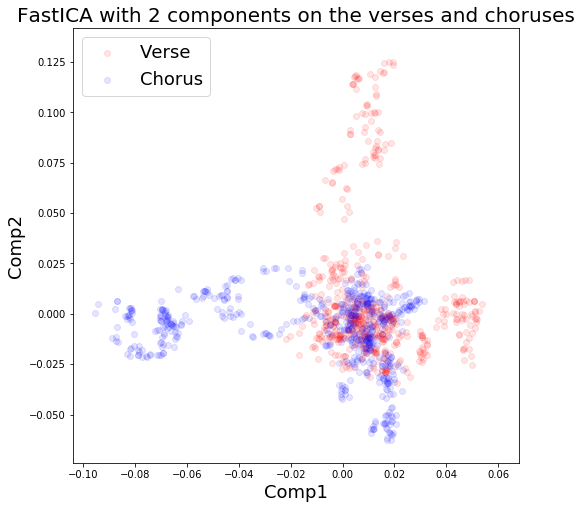

In [349]:
fastICA_results = FastICA_visualization(df_bow_verse, df_bow_chorus, vocab)

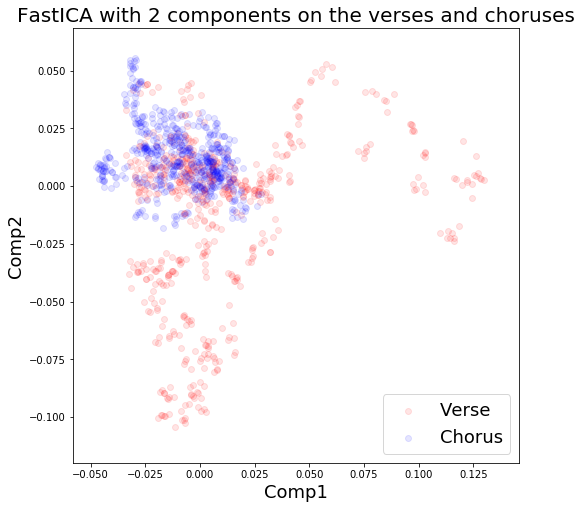

In [278]:
fastICA_results_rel = FastICA_visualization(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative)

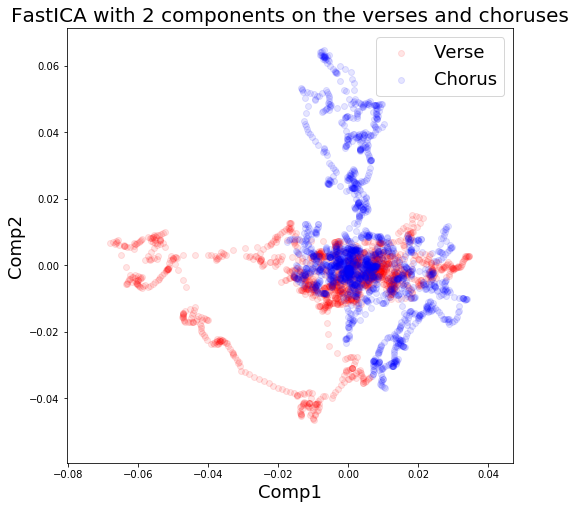

In [280]:
fastICA_results_rel_seq = FastICA_visualization(df_bow_verse_rel_seq, df_bow_chorus_rel_seq, vocab_relative)

### t-SNE

Important articles:
* [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)
* [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
* [t-SNE Python Example](https://towardsdatascience.com/t-sne-python-example-1ded9953f26)
* [Visualizing Data using t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)

In [172]:
from sklearn.manifold import TSNE

In [350]:
def TSNE_visualization(df1, df2, vocab = vocab, n_comps = 12, verbose = 0, perplexity = 30):
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df1.loc[:, features].values, df2.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df1)), np.ones(len(df2))))
    model = TSNE(n_components = n_comps, verbose = verbose, perplexity = perplexity, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = (8,8))
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = 0.2,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = 0.2,
                label = 'Chorus')
    settings = '(perp = ' + str(perplexity) + ', N = ' + str(len(X)) + ')'
    title = 'TSNE with 2 components on the verses and choruses ' + settings
    plt.title(title, fontsize = 20)
    plt.xlabel('Comp1', fontsize = 18)
    plt.ylabel('Comp2', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.show()
    
    if verbose == 0:
        print('KL divergence: %f' %model.kl_divergence_)
    
    return (model, len(X))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1170 samples in 0.032s...
[t-SNE] Computed neighbors for 1170 samples in 1.243s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1170
[t-SNE] Computed conditional probabilities for sample 1170 / 1170
[t-SNE] Mean sigma: 0.000511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.687744
[t-SNE] KL divergence after 1000 iterations: 0.107606


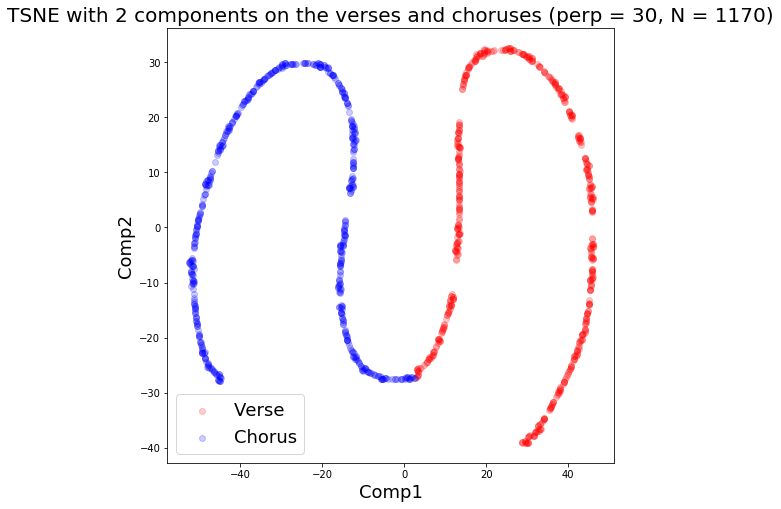

In [183]:
tsne_results = TSNE_visualization(df_bow_verse, df_bow_chorus, vocab, 2, 1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1170 samples in 0.015s...
[t-SNE] Computed neighbors for 1170 samples in 0.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1170
[t-SNE] Computed conditional probabilities for sample 1170 / 1170
[t-SNE] Mean sigma: 0.000470
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.519691
[t-SNE] KL divergence after 1000 iterations: 0.125356


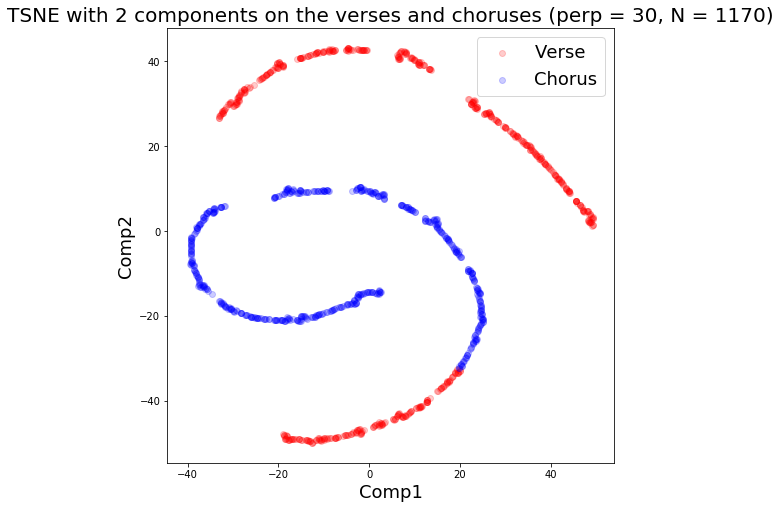

In [184]:
tsne_results_rel = TSNE_visualization(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative, 2, 1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3480 samples in 0.051s...
[t-SNE] Computed neighbors for 3480 samples in 2.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3480
[t-SNE] Computed conditional probabilities for sample 2000 / 3480
[t-SNE] Computed conditional probabilities for sample 3000 / 3480
[t-SNE] Computed conditional probabilities for sample 3480 / 3480
[t-SNE] Mean sigma: 0.000176
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.401665
[t-SNE] KL divergence after 1000 iterations: 0.181611


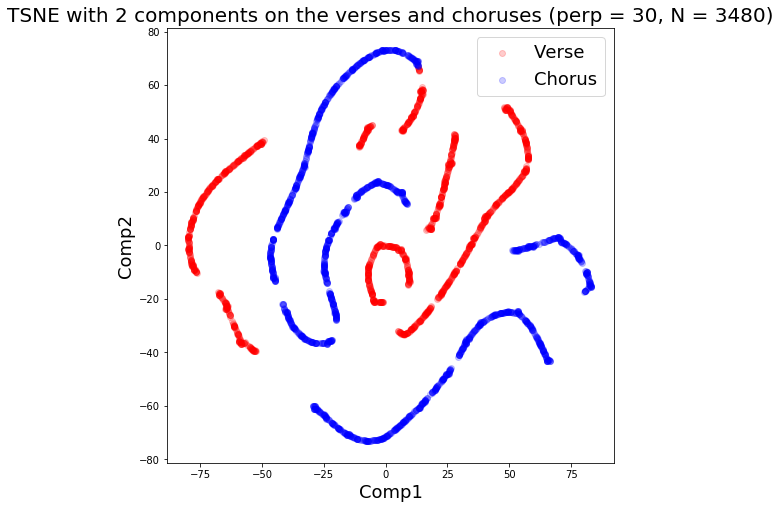

In [185]:
tsne_results_rel_seq = TSNE_visualization(df_bow_verse_rel_seq, df_bow_chorus_rel_seq, vocab_relative, 2, 1)

An important hyperparameter to tweak for the tSNE is the perplexity. It relates to the number of neighbours that are considered for each point. The authors of [Automatic Selection of t-SNE Perplexity](https://arxiv.org/pdf/1708.03229.pdf) propose a measure to automatically choose the best perplexity, using the KL divergence that the tSNE algorithm uses as a criterion for convergence. To do so, they define the function S as a function of the perplexity and aim at minimizing it. We implement this approach here.

In [201]:
import math

In [202]:
def S_perp(perp, model, N):
    return (2 * model.kl_divergence_ + math.log(N) * perp / N)

PERPLEXITY: 30


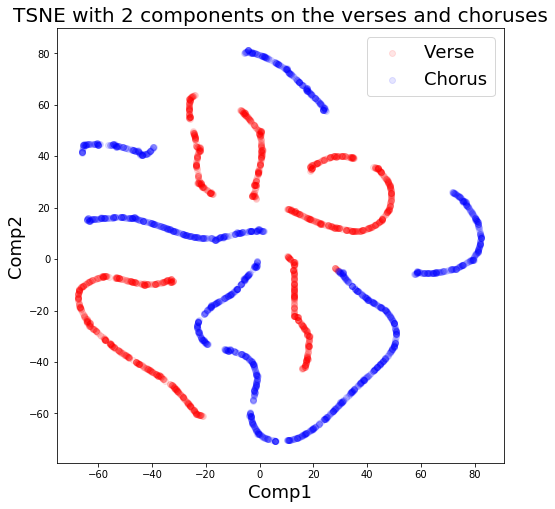

KL divergence: 0.183198
PERPLEXITY: 50


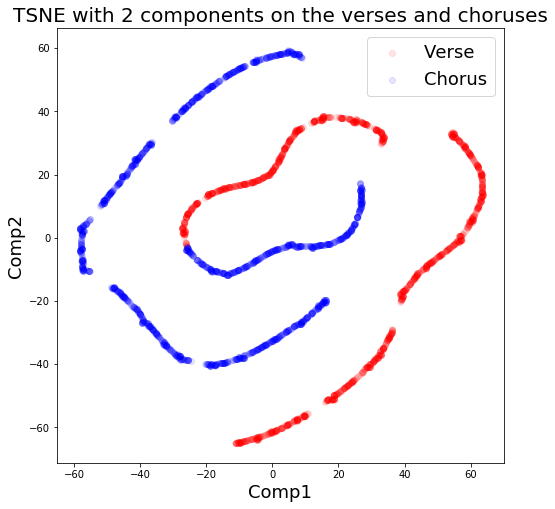

KL divergence: 0.143344
PERPLEXITY: 100


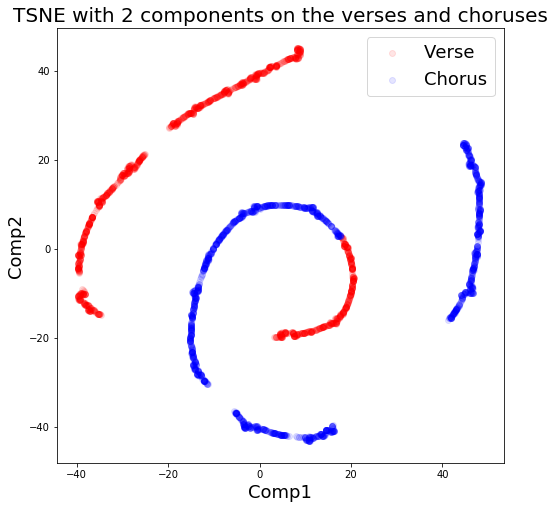

KL divergence: 0.124186
PERPLEXITY: 200


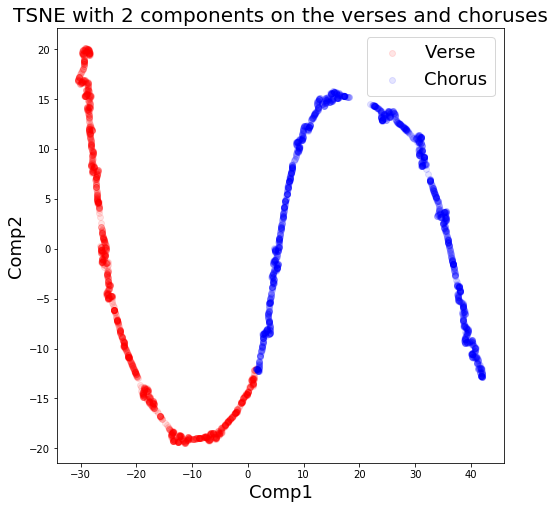

KL divergence: 0.093055
PERPLEXITY: 300


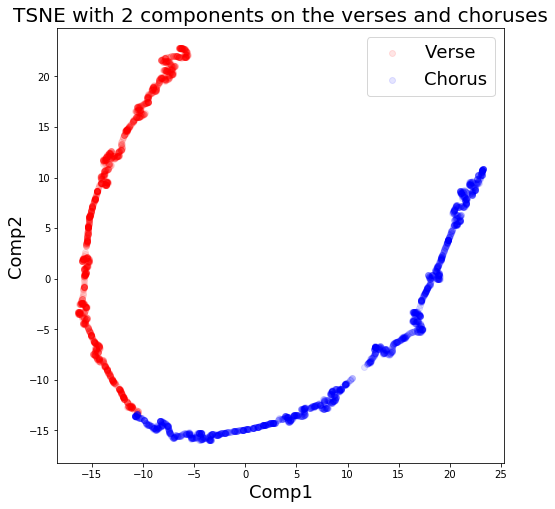

KL divergence: 0.079817
PERPLEXITY: 400


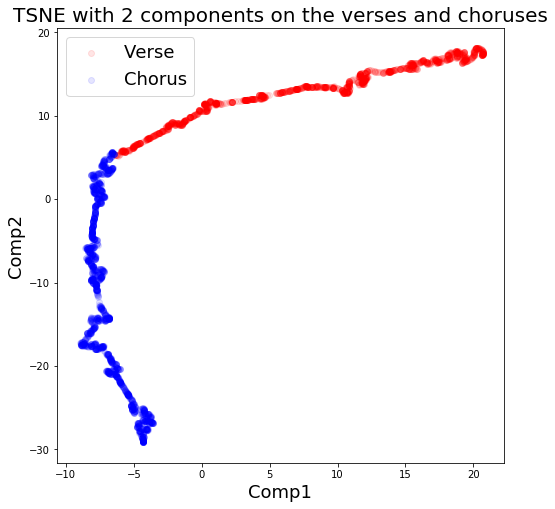

KL divergence: 0.070438
PERPLEXITY: 500


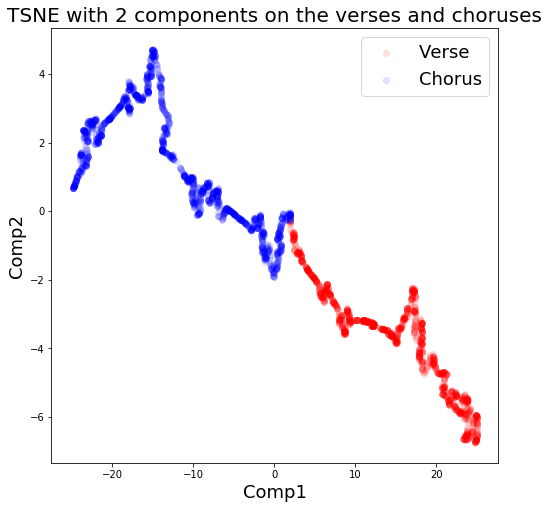

KL divergence: 0.065902
PERPLEXITY: 600


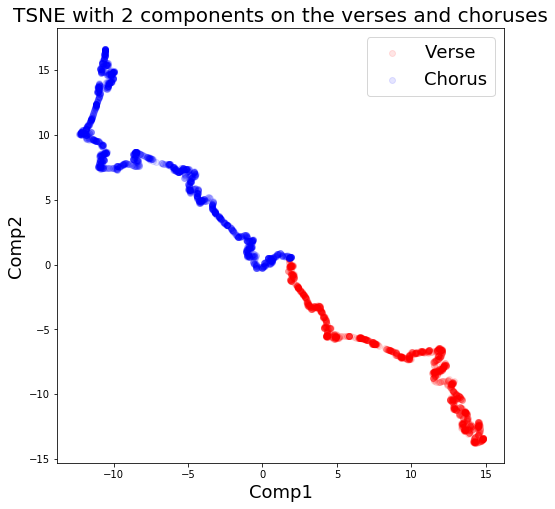

KL divergence: 0.061183
PERPLEXITY: 750


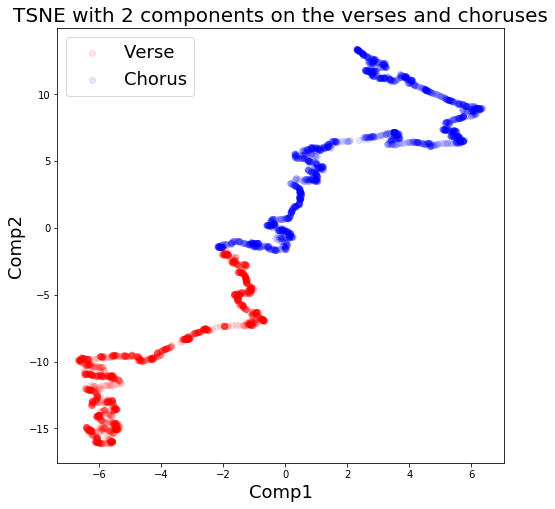

KL divergence: 0.056642
PERPLEXITY: 1000


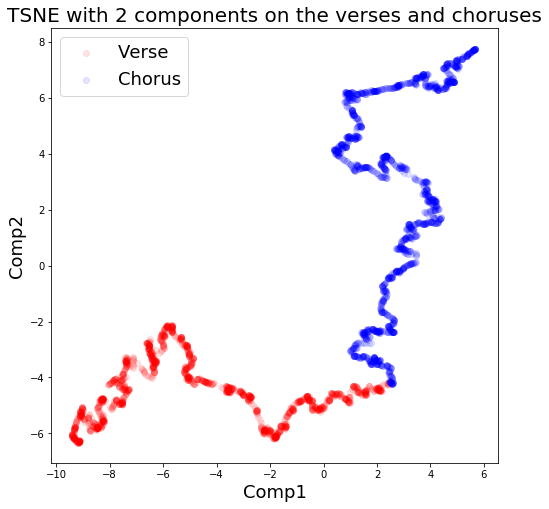

KL divergence: 0.042797


In [86]:
perplexity_list = [30, 50, 100, 200, 300, 400, 500, 600, 750, 1000]
S_list = list()
for i in range(len(perplexity_list)):
    print('PERPLEXITY: %d' %perplexity_list[i])
    (model,N) = TSNE_visualization(df_bow_verse_rel_seq, df_bow_chorus_rel_seq, vocab_relative, 2, 0, perplexity_list[i])
    S_list.append((S_perp(perplexity_list[i], model, N)))

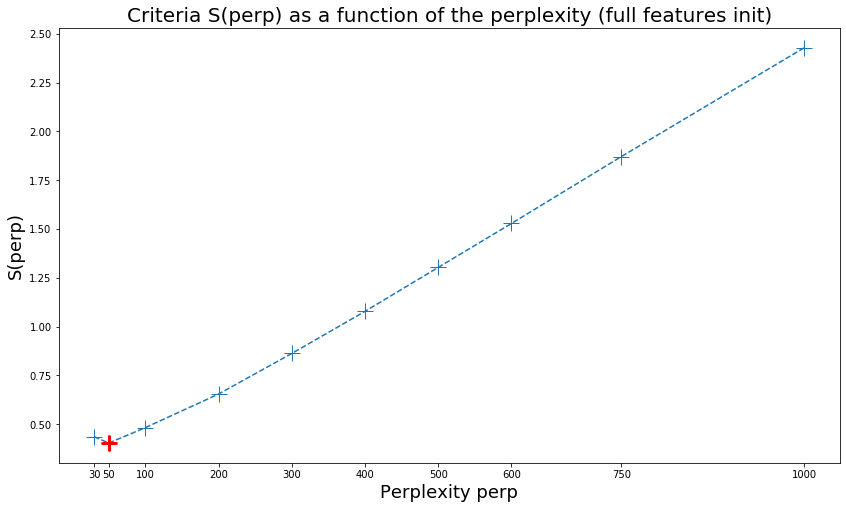

In [87]:
plt.figure(figsize = (14,8))
plt.plot(perplexity_list, S_list, marker = '+', markersize = 16, linestyle = 'dashed')
plt.plot(perplexity_list[np.argmin(S_list)], np.min(S_list), 
         marker = '+', markersize = 16, markeredgewidth = 3, color = 'red')
plt.xlabel('Perplexity perp' , fontsize = 18)
plt.ylabel('S(perp)', fontsize = 18)
plt.xticks(perplexity_list)
plt.title('Criteria S(perp) as a function of the perplexity (full features init)', fontsize = 20)
plt.show()

#### TSNE initialized with PCA

In [295]:
def TSNE_PCAinit(df1, df2, vocab = vocab, pca_comps = 15, verbose = 0, perplexity = 50):
    ##Create input
    features = vocab.keys()
    X = np.concatenate((df1.loc[:, features].values, df2.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df1)), np.ones(len(df2))))
    ##PCA
    pca_model = PCA(n_components = pca_comps, random_state = 42)
    pca_result = pca_model.fit_transform(X)

    ##TSNE initialized with PCA
    tsne_model = TSNE(n_components = 2, verbose = verbose, perplexity = perplexity, random_state = 42)
    tsne_pca_results = tsne_model.fit_transform(pca_result)

    principalDf = pd.DataFrame(data = tsne_pca_results[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y

    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = (8,8))
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = 0.1,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = 0.1,
                label = 'Chorus')
    settings = '(PCA components = ' + str(pca_comps) + ', perp = ' + str(perplexity) + ', N = ' + str(len(X)) + ')'
    title = 'TSNE initialized with PCA with 2 components on the verses and choruses \n' + settings
    plt.title(title, fontsize = 20)
    plt.xlabel('Comp1', fontsize = 18)
    plt.ylabel('Comp2', fontsize = 18)
    plt.legend(fontsize = 18)
    lim = 0.004
    #plt.axis([-lim,lim,-lim,lim])
    plt.show()
    
    return (tsne_model, pca_model, len(X))

PERPLEXITY: 10


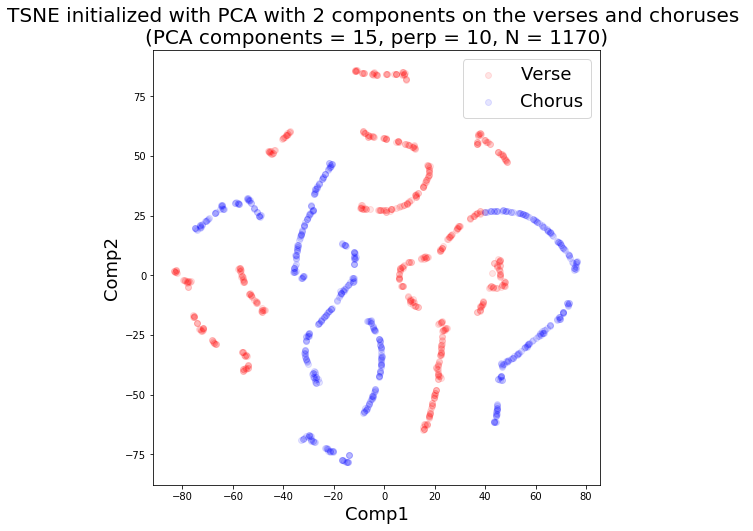

PCA explained variance: 0.984060
PERPLEXITY: 20


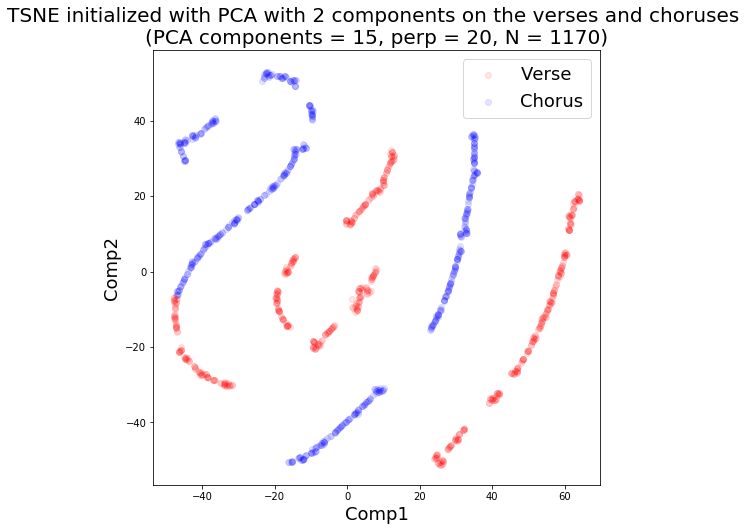

PCA explained variance: 0.984060
PERPLEXITY: 30


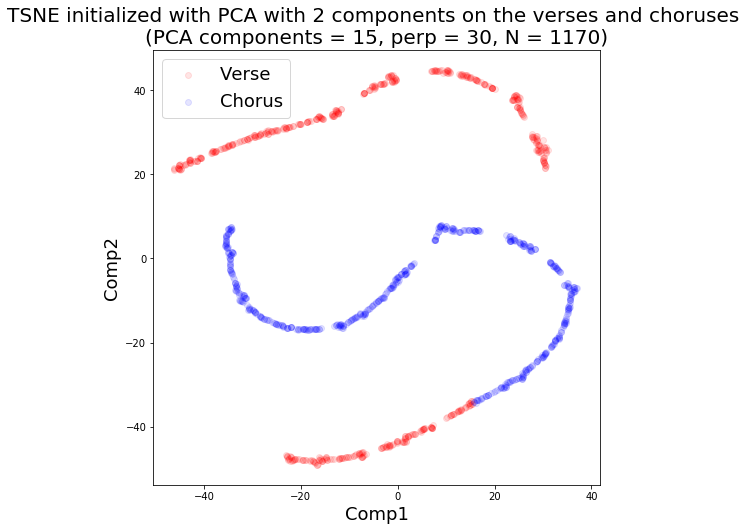

PCA explained variance: 0.984060
PERPLEXITY: 40


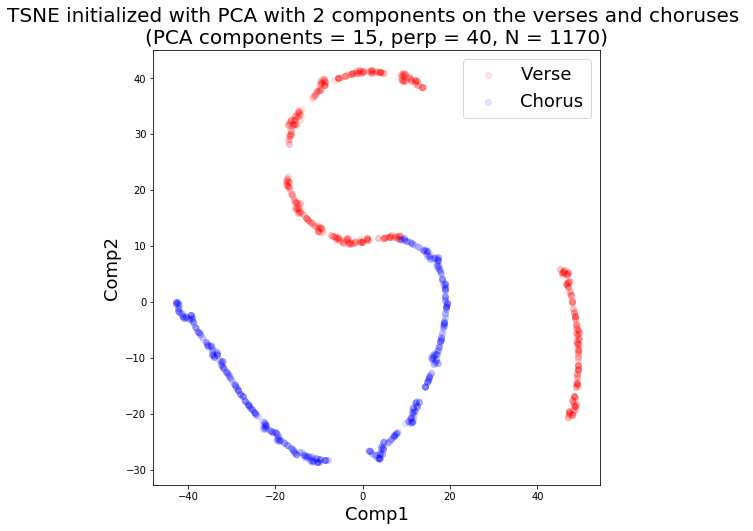

PCA explained variance: 0.984060
PERPLEXITY: 50


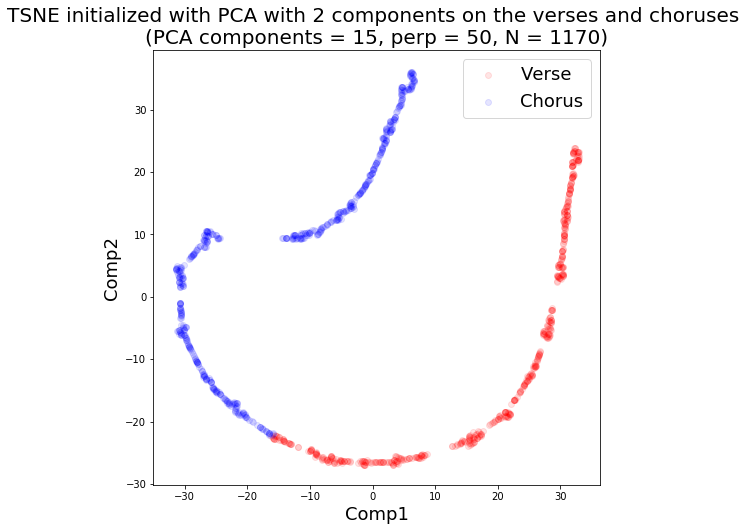

PCA explained variance: 0.984060
PERPLEXITY: 60


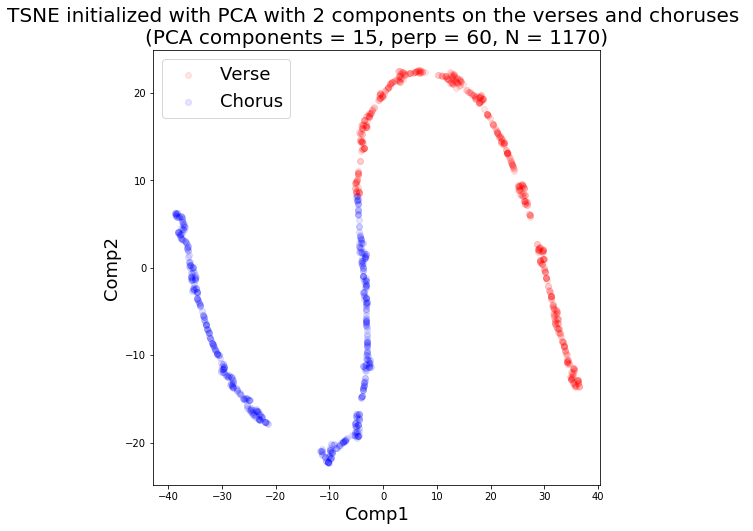

PCA explained variance: 0.984060


In [207]:
perplexity_list = [10, 20, 30, 40, 50, 60]
S_list_PCAinit = list()
for i in range(len(perplexity_list)):
    print('PERPLEXITY: %d' %perplexity_list[i])
    (model_tsne,model_pca,N) = TSNE_PCAinit(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative, 15, 0, perplexity_list[i])
    print('PCA explained variance: %f' %model_pca.explained_variance_ratio_.sum())
    S_list_PCAinit.append((S_perp(perplexity_list[i], model_tsne, N)))

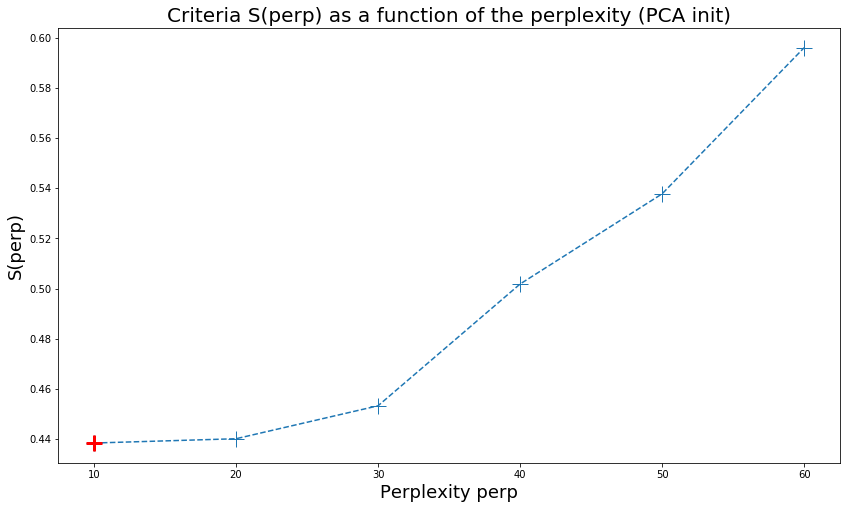

In [208]:
plt.figure(figsize = (14,8))
plt.plot(perplexity_list, S_list_PCAinit, marker = '+', markersize = 16, linestyle = 'dashed')
plt.plot(perplexity_list[np.argmin(S_list_PCAinit)], np.min(S_list_PCAinit), 
         marker = '+', markersize = 16, markeredgewidth = 3, color = 'red')
plt.xlabel('Perplexity perp' , fontsize = 18)
plt.ylabel('S(perp)', fontsize = 18)
plt.xticks(perplexity_list)
plt.title('Criteria S(perp) as a function of the perplexity (PCA init)', fontsize = 20)
plt.show()

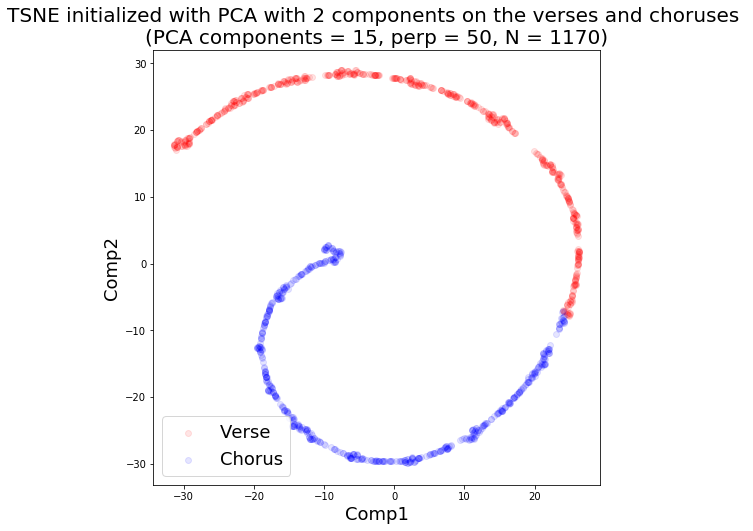

In [195]:
(model_tsne,model_pca,N) = TSNE_PCAinit(df_bow_verse, df_bow_chorus, vocab, 15, 0, 50)

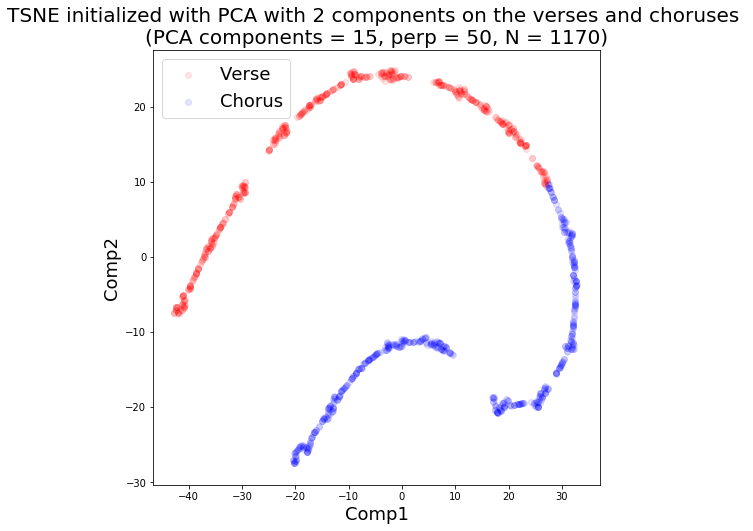

In [297]:
(model_tsne,model_pca,N) = TSNE_PCAinit(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative, 15, 0, 50)

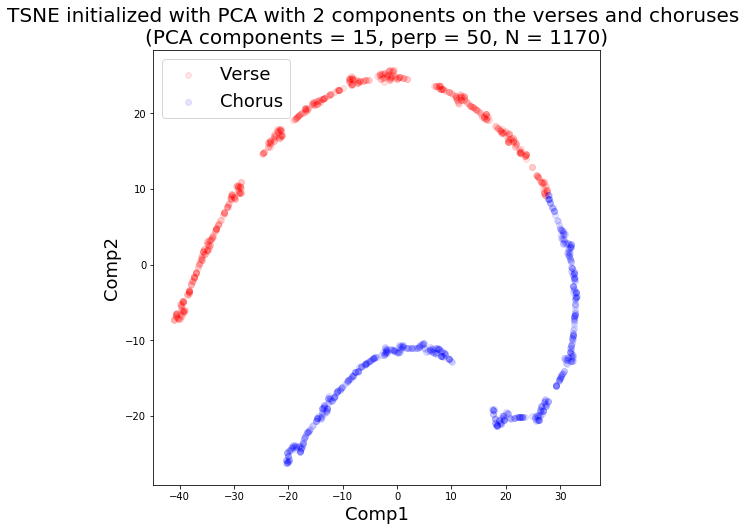

In [298]:
(model_tsne,model_pca,N) = TSNE_PCAinit(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative, 15, 0, 50)

### KMeans on the reduced-dimension space

In [91]:
from sklearn.cluster import KMeans

In [92]:
def GetOptimalK(X, k_range = 10):
    inertia_values = []
    for k in range(1,k_range):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)
    plt.figure(figsize = (16,5))
    plt.scatter(x = np.arange(1,k_range), y = inertia_values)
    plt.xticks(np.arange(1,k_range))
    plt.title('k-value optimization by elbow method', fontsize = 20)
    plt.xlabel('k value', fontsize = 18)
    plt.ylabel('Inertia', fontsize = 18)
    plt.show()

In [93]:
def KMeans_visualization(X, k):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    labels = kmeans.labels_
    n_verse = len(df_bow_verse_rel_seq)
    n_chorus = len(df_bow_chorus_rel_seq)
    plt.figure(figsize = (8,8))
    plt.scatter(x = X[:n_verse,0], y = X[:n_verse,1], marker = '+', c = labels[:n_verse].astype(np.float), alpha = 0.1, label = 'Verse')
    plt.scatter(x = X[n_chorus:,0], y = X[n_chorus:,1], marker = 'o', c = labels[n_chorus:].astype(np.float), alpha = 0.1, label = 'Chorus')
    plt.title('Kmeans clustering with optimal k on output of TSNE with PCA init', fontsize = 20)
    plt.xlabel('Comp1', fontsize = 18)
    plt.ylabel('Comp2', fontsize = 18)
    plt.legend()
    plt.show()

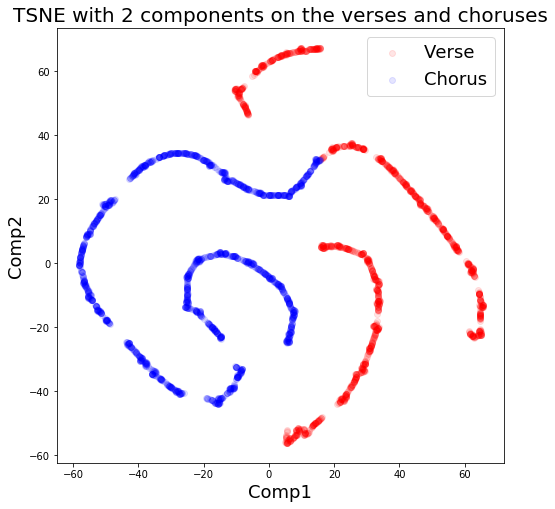

In [94]:
(model_tsne,model_pca,N) = TSNE_PCAinit(df_bow_verse_rel_seq, df_bow_chorus_rel_seq, vocab_relative, 15, 0, 50)

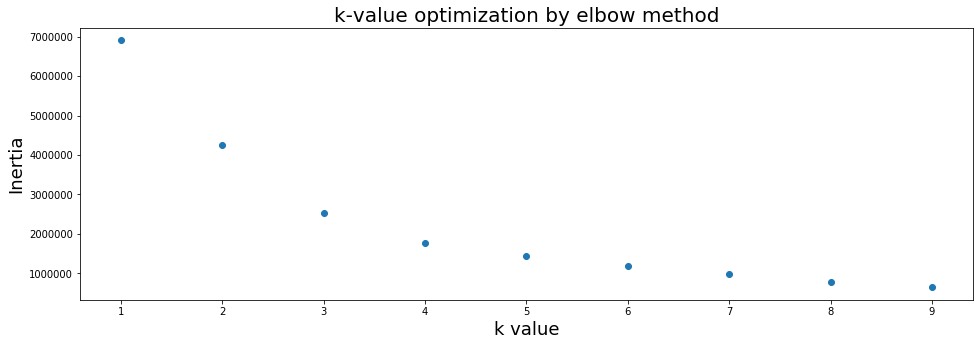

In [95]:
X = model_tsne.embedding_
GetOptimalK(X)

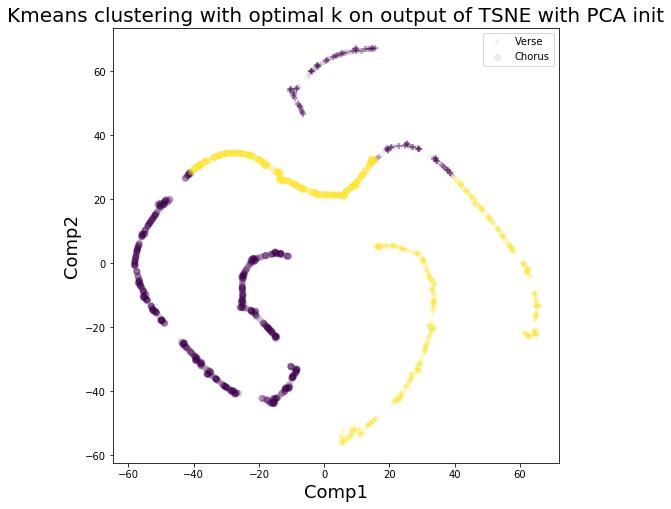

In [100]:
KMeans_visualization(X, 3)

### DBSCAN clustering on the results of the dimensionality reduction algorithms

In [101]:
from sklearn.cluster import DBSCAN

In [104]:
def DBSCAN_visualization(X, eps = 3, min_samples = 2):
    dbscan = DBSCAN(eps=3, min_samples=2).fit(X)
    labels = dbscan.labels_
    n_verse = len(df_bow_verse_rel_seq)
    n_chorus = len(df_bow_chorus_rel_seq)
    plt.figure(figsize = (8,8))
    plt.scatter(x = X[:n_verse,0], y = X[:n_verse,1], marker = '+', c = labels[:n_verse].astype(np.float), alpha = 0.2, label = 'Verse')
    plt.scatter(x = X[n_chorus:,0], y = X[n_chorus:,1], marker = 'o', c = labels[n_chorus:].astype(np.float), alpha = 0.2, label = 'Chorus')
    plt.title('Kmeans clustering with optimal k on output of TSNE with PCA init', fontsize = 20)
    plt.xlabel('Comp1', fontsize = 18)
    plt.ylabel('Comp2', fontsize = 18)
    plt.legend()
    plt.show()
    
    print('DBSCAN clustering has identified %d clusters.' % len(np.unique(labels)))

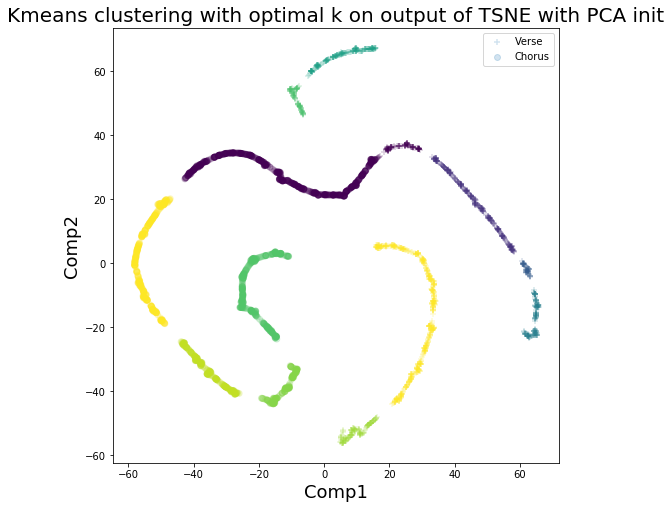

DBSCAN clustering has identified 12 clusters.


In [105]:
DBSCAN_visualization(X, 3, 10)

### Aggregated features engineering

In [290]:
def LabelMinMajChord(chord):
    label = 'other'
    if 'min' in chord: #This will label minmaj7 as a minor chord
        label = 'min' 
    elif 'maj' in chord:
        label = 'maj'
    return label

In [300]:
beats_collection_df['agg_chord_label'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'].map(lambda x: LabelMinMajChord(x))

In [323]:
features_agg = beats_collection_df.agg_chord_label.unique()
features_agg

array(['0.0maj', '5.0maj', '11.0other', '4.0other', '9.0min', '2.0min',
       '7.0other', '4.0min', '7.0maj', '0.0other', '10.0maj', '10.0other',
       '7.0min', 'nanother', '4.0maj', '0.0min', '8.0maj', '5.0min',
       '3.0maj', '5.0other', '9.0other', '8.0other', '2.0other', '2.0maj',
       '6.0maj', '1.0maj', '9.0maj', '3.0other', '6.0other', '1.0other',
       '1.0min', '3.0min', '6.0min', '10.0min', '8.0min', '11.0min',
       '11.0maj'], dtype=object)

In [324]:
features_agg = np.delete(features_agg, 13)
features_agg = dict.fromkeys(features_agg)

In [326]:
df_bow_verse_agg = createBOW_df_section(beats_collection_df, section = 'verse', vocab = features_agg, chord = 'agg_chord_label')
df_bow_chorus_agg = createBOW_df_section(beats_collection_df, section = 'chorus', vocab = features_agg, chord = 'agg_chord_label')

In [329]:
df_bow_verse_agg.head()

,song_id,0.0maj,5.0maj,11.0other,4.0other,9.0min,2.0min,7.0other,4.0min,7.0maj,...,3.0other,6.0other,1.0other,1.0min,3.0min,6.0min,10.0min,8.0min,11.0min,11.0maj
0,4,0.273262,0.136498,0.000743,0.004208,0.036906,0.043039,0.063390,0.017643,0.087299,...,0.002761,0.000943,0.000199,0.000040,0.001155,0.0,0.001235,0.000266,0.000597,0.000133
1,10,0.273577,0.136471,0.000740,0.004191,0.036755,0.043921,0.063132,0.017571,0.088002,...,0.002750,0.000939,0.000198,0.000040,0.001150,0.0,0.001230,0.000264,0.000595,0.000132
2,12,0.273748,0.136874,0.000739,0.004184,0.036693,0.043847,0.063025,0.017542,0.088275,...,0.002745,0.000937,0.000198,0.000040,0.001148,0.0,0.001228,0.000264,0.000594,0.000132
3,16,0.273056,0.136528,0.000737,0.004174,0.036601,0.043736,0.062866,0.017497,0.088052,...,0.002738,0.000935,0.000197,0.000039,0.001145,0.0,0.001224,0.000263,0.000592,0.000132
4,18,0.273018,0.136299,0.000736,0.004167,0.036539,0.043663,0.062760,0.017468,0.087904,...,0.002734,0.000933,0.000197,0.000039,0.001143,0.0,0.001222,0.000263,0.000591,0.000131


PCA_visualization(df1, df2, vocab = vocab, n_comps = 12, n_weights = 10, prop_variance = 0.95)

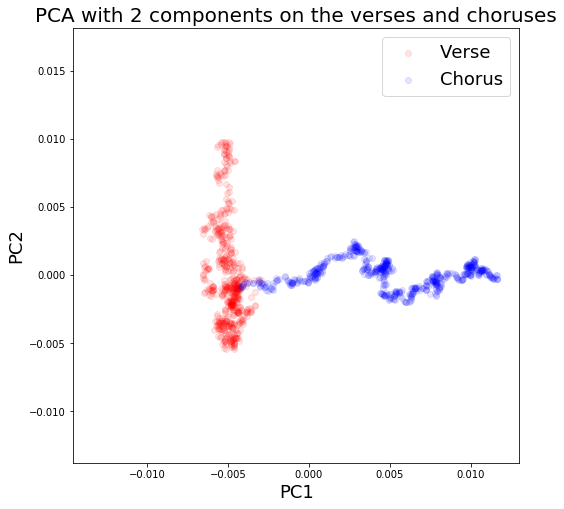

The first 2 components explain respectively 69.72% and 15.28% of the variance,
for a total of 85.00% of the total variance.


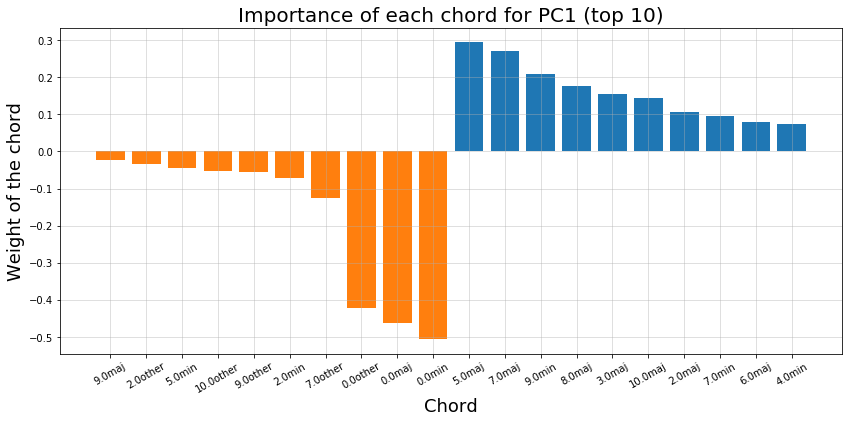

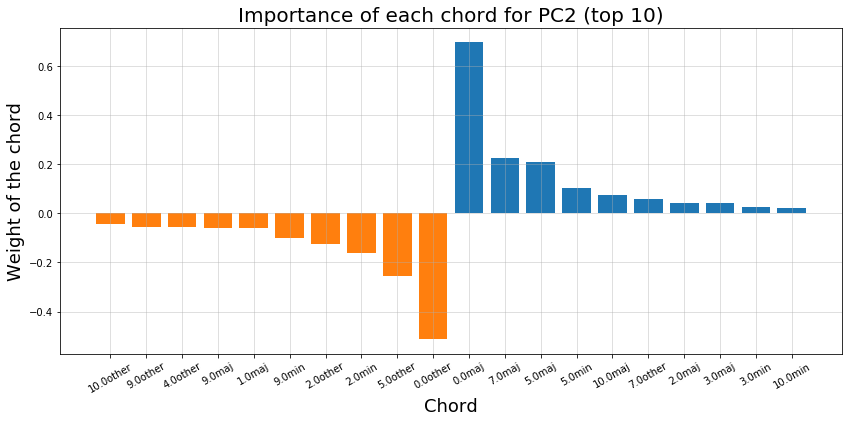

The mininum number of PCs to explain 95.00% of the variance is 5.


In [340]:
results_pca = PCA_visualization(df_bow_verse_agg, df_bow_chorus_agg, vocab = features_agg, n_weights = 10)

FastICA_visualization(df1, df2, vocab = vocab, n_comps = 12, n_weights = 10, prop_variance = 0.95)

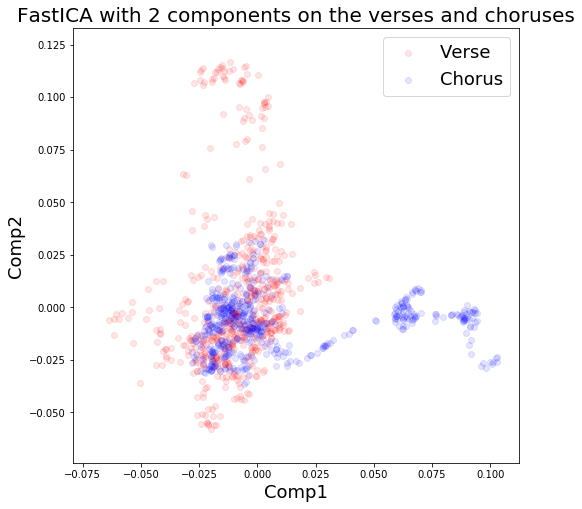

In [339]:
results_ica = FastICA_visualization(df_bow_verse_agg, df_bow_chorus_agg, vocab = features_agg)

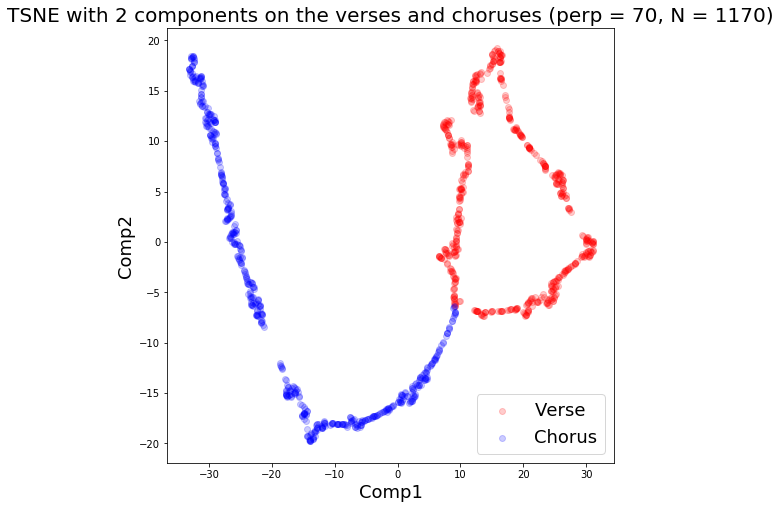

KL divergence: 0.138681


In [358]:
results_tsne = TSNE_visualization(df_bow_verse_agg, df_bow_chorus_agg, vocab = features_agg, n_comps = 2, perplexity = 70)

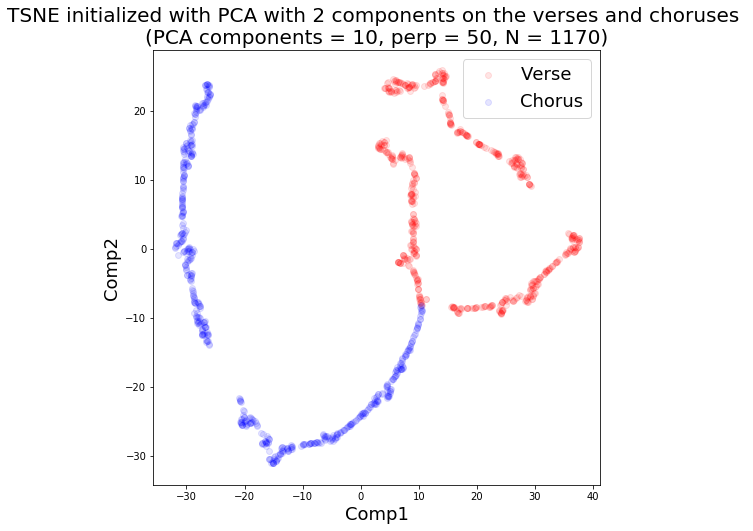

In [356]:
tsne_pca_init_results = TSNE_PCAinit(df_bow_verse_agg, df_bow_chorus_agg, vocab = features_agg, pca_comps = 10, perplexity = 50)

### Other PCA explorations

In [ ]:
features = vocab.keys()
def pca_visualization(df, title, vocab = vocab, n_comps = 2):
    pca = PCA(n_components = n_comps)
    principalComponents = pca.fit_transform(df.loc[:, features].values)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    plt.scatter(principalDf['PC1'], principalDf['PC2'])
    plt.title(title, fontsize = 20)
    plt.xlabel('PC1', fontsize = 18)
    plt.ylabel('PC2', fontsize = 18)
    plt.show()
    
    print('The first 2 components explain for %0.2f%% and %0.2f%% of the variance,' %(100 * pca.explained_variance_ratio_[0],
                                                                                     100 * pca.explained_variance_ratio_[1]))
    print('for a total of %0.2f%% of the total variance.' % (100 * (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])))

In [ ]:
pca_visualization(df_bow, '2 components PCA for the whole songs')

In [ ]:
pca_visualization(df_bow_verse, '2 components PCA for the verses of the songs')

In [ ]:
pca_visualization(df_bow_chorus, '2 components PCA for the choruses of the songs')

In [59]:
def MinNumberCompRequired(df, prop_variance = 0.95, section = 'whole songs'):
    pca = PCA(prop_variance)
    pca.fit(df.loc[:, features].values)
    print('The mininum number of PCs to explain %0.2f%% of the variance for the %s is %d.' % (100 * prop_variance, section, pca.n_components_))

In [ ]:
prop_variance_explained = 0.95
MinNumberCompRequired(df_bow, prop_variance_explained)
MinNumberCompRequired(df_bow_verse, prop_variance_explained, 'verses of the songs')
MinNumberCompRequired(df_bow_chorus, prop_variance_explained, 'choruses of the songs')

Let's test a logistic regression using the PCs of PCA as input.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [61]:
pca = PCA(12)
PCs_verse = pca.fit_transform(df_bow_verse.loc[:, features].values)

In [62]:
pca = PCA(12)
PCs_chorus = pca.fit_transform(df_bow_chorus.loc[:, features].values)

In [63]:
X = np.concatenate((PCs_verse, PCs_chorus))
y = np.concatenate((np.zeros(len(PCs_verse)), np.ones(len(PCs_chorus)))) #0 for verses & 1 for chorus

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The first classifier we test is a simple logistic regression. We use the cross-validation version to directly find the best hyperparameter value.

In [ ]:
logreg_model = LogisticRegressionCV(cv = 10)
logreg_preds = logreg_model.fit(X_train, y_train).predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_preds)
print('Logistic Regression Accuracy: {}'.format(logreg_acc))

### K-Means

In [818]:
from sklearn.cluster import KMeans

In [71]:
def ClusteringVisualization_KMeans(X, title):
    kmeans = KMeans(n_clusters = 2)
    data = kmeans.fit_transform(X)
    labels = kmeans.labels_
    plt.scatter(x = data[:,0], y = data[:,1], c = labels.astype(np.float))
    plt.title(title, fontsize = 20)
    plt.show()

In [ ]:
ClusteringVisualization_KMeans(df_bow.loc[:, features].values, 'Clustering with k-means (k = 2) for the whole songs')

In [ ]:
ClusteringVisualization_KMeans(df_bow_verse.loc[:, features].values, 'Clustering with k-means (k = 2) for the verses')

In [ ]:
ClusteringVisualization_KMeans(df_bow_chorus.loc[:, features].values, 'Clustering with k-means (k = 2) for the choruses')

In [75]:
def GetOptimalK(X, title):
    inertia_values = []
    for k in range(1,20):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)
    plt.figure(figsize = (16,5))
    plt.scatter(x = np.arange(1,20), y = inertia_values)
    plt.xticks(np.arange(1,20))
    plt.title(title, fontsize = 20)
    plt.xlabel('k value', fontsize = 18)
    plt.ylabel('Inertia', fontsize = 18)
    plt.show()

In [ ]:
GetOptimalK(df_bow.loc[:, features].values, 'Determination of the most optimal k for k-means clustering for the whole songs')

In [ ]:
GetOptimalK(df_bow_verse.loc[:, features].values, 'Determination of the most optimal k for k-means clustering for the verses')

In [ ]:
GetOptimalK(df_bow_chorus.loc[:, features].values, 'Determination of the most optimal k for k-means clustering for the choruses')

### Pairwise distance

In [825]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

In [826]:
def createDistDf(df1, df2, features, distance = euclidean):
    #Compute the distances
    intra_dist_verse = pdist(df1.loc[:, features].values, distance)
    intra_dist_chorus = pdist(df2.loc[:, features].values, distance)
    between_dist = cdist(df1.loc[:, features].values, df2.loc[:, features].values, distance).flatten()
    dist_df = pd.DataFrame({'distance':intra_dist_verse, 'section':'intra_verse'})\
                          .append(pd.DataFrame({'distance':intra_dist_chorus, 'section':'intra_chorus'}))\
                          .append(pd.DataFrame({'distance':between_dist, 'section':'between_groups'}))

    #Plot the results in boxplots
    boxplot = dist_df.boxplot(by = 'section', figsize = (14,6), notch = True, grid = False, showmeans = True)
    boxplot.set_xlabel('Type of distance', fontsize = 18)
    boxplot.set_ylabel('Distance', fontsize = 18)
    plt.title("Boxplots for the intra- and between-group distances for choruses and verses", fontsize = 20)
    plt.suptitle("")
    plt.xticks(range(1,4), ['Between-groups', 'Intra-chorus', 'Intra-verse'], fontsize = 14)
    plt.show()

    return dist_df

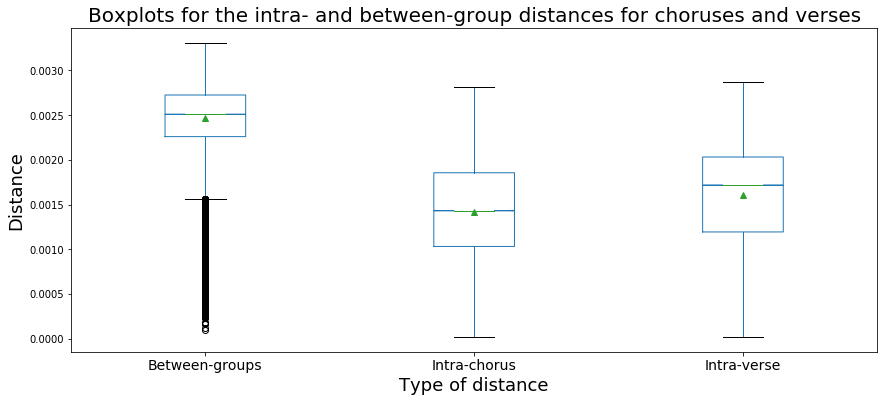

In [827]:
dist_df = createDistDf(df_bow_verse, df_bow_chorus, vocab.keys())
#dist_df_rel = createDistDf(df_bow_verse_rel, df_bow_chorus_rel, vocab_relative.keys())

In [828]:
rp.summary_cont(dist_df.groupby('section'))

distance                                                      
                      N      Mean        SD            SE 95% Conf.  Interval
section                                                                      
between_groups   342225  0.002468  0.000397  6.779271e-07  0.002467  0.002469
intra_chorus     170820  0.001415  0.000545  1.318547e-06  0.001413  0.001418
intra_verse      170820  0.001606  0.000571  1.380742e-06  0.001604  0.001609

Let's do an ANOVA to test if the differences between these groups are indeed significant. We follow the procedure explained by Corey Bryant in https://pythonfordatascience.org/anova-python/.

In [829]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [830]:
results = ols('distance ~ C(section)', data = dist_df).fit()

In [831]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 3.412e+05
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        22:57:31   Log-Likelihood:             4.2499e+06
No. Observations:              683865   AIC:                        -8.500e+06
Df Residuals:                  683862   BIC:                        -8.500e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0025   8.27e-07   2983.320      0.000       0.002       0.002
C(section)[T.intra_chorus]    -0.0011   1.43e-06   -734.411      0.000      -0.001      -0.001
C(section)[T.intra_verse]     -0.0009   1.43e-06   -601.135      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    38980.282   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46364.983
Skew:                          -0.604   Prob(JB):                         0.00
Kurtosis:                       3.409   Cond. No.                         3.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's check for the assumptions of ANOVA.

In [832]:
results.diagn

{'jb': 46364.98345400562,
 'jbpv': 0.0,
 'skew': -0.6041582592484125,
 'kurtosis': 3.408820090452597,
 'omni': 38980.28226464524,
 'omnipv': 0.0,
 'condno': 3.2248371385529917,
 'mineigval': 74975.16637462519}

This function, provided by the author of the article, computes the effect sizes as well as the mean squares. The ANOVA table is computed using the most robust heteroscedasticity-corrected coefficient covariance matrix possible (hc2 and hc3 raise an error) since the omnibus test is significant (omnipv < 0.05).

In [833]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [834]:
aov_table = sm.stats.anova_lm(results, typ=2, robust = 'hc1')
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(section),0.160645,2.0,8.032240e-02,342913.507302,0.0,0.500717,0.500715
Residual,0.160185,683862.0,2.342352e-07,NaN,NaN,NaN,NaN


We can also try using the cosine distance (not the cosine similarity!).

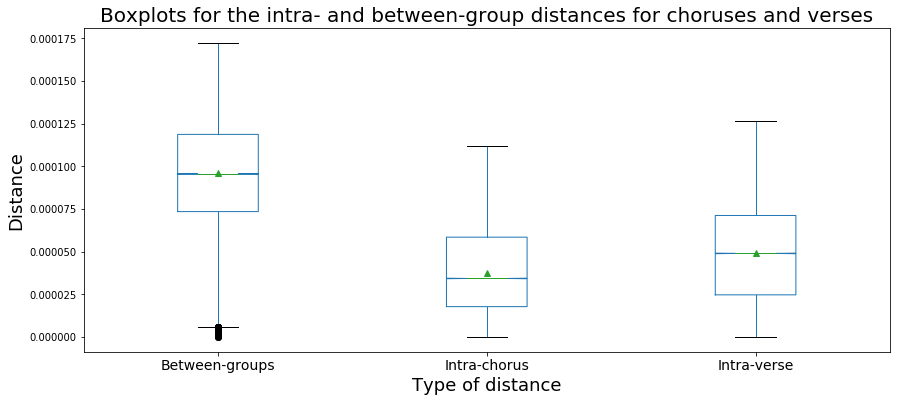

In [835]:
dist_df_cosine = createDistDf(df_bow_verse, df_bow_chorus, vocab.keys(), cosine)

In [836]:
rp.summary_cont(dist_df_cosine.groupby('section'))

distance                                                      
                      N      Mean        SD            SE 95% Conf.  Interval
section                                                                      
between_groups   342225  0.000096  0.000030  5.193080e-08  0.000096  0.000096
intra_chorus     170820  0.000038  0.000024  5.792380e-08  0.000038  0.000038
intra_verse      170820  0.000049  0.000029  7.043612e-08  0.000049  0.000050

Again, we apply an ANOVA to test the significance of these results.

In [837]:
results = ols('distance ~ C(section)', data = dist_df_cosine).fit()

In [838]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                 2.931e+05
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        22:57:53   Log-Likelihood:             6.1848e+06
No. Observations:              683865   AIC:                        -1.237e+07
Df Residuals:                  683862   BIC:                        -1.237e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   9.584e-05   4.89e-08   1961.929      0.000    9.57e-05    9.59e-05
C(section)[T.intra_chorus] -5.809e-05   8.47e-08   -686.131      0.000   -5.83e-05   -5.79e-05
C(section)[T.intra_verse]  -4.646e-05   8.47e-08   -548.781      0.000   -4.66e-05   -4.63e-05
==============================================================================
Omnibus:                    11199.416   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6348.456
Skew:                           0.007   Prob(JB):                         0.00
Kurtosis:                       2.528   Cond. No.                         3.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's check for the assumptions of ANOVA.

In [839]:
results.diagn

{'jb': 6348.455611540174,
 'jbpv': 0.0,
 'skew': 0.0074614386229123215,
 'kurtosis': 2.528222394275933,
 'omni': 11199.416470266977,
 'omnipv': 0.0,
 'condno': 3.2248371385529917,
 'mineigval': 74975.16637462519}

As before, the ANOVA table is computed using the most robust heteroscedasticity-corrected coefficient covariance matrix possible since the omnibus test is significant (omnipv < 0.05).

In [840]:
aov_table = sm.stats.anova_lm(results, typ=2, robust = 'hc1')
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(section),0.000509,2.0,2.544531e-04,311562.050677,0.0,0.476764,0.476762
Residual,0.000559,683862.0,8.167012e-10,NaN,NaN,NaN,NaN


### Linear classifier to discriminate between choruses and verses

In [841]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [842]:
features = vocab_relative.keys()
X = np.concatenate((df_bow_verse_rel.loc[:, features].values, df_bow_chorus_rel.loc[:, features].values))
y = np.concatenate((np.zeros(len(df_bow_verse_rel)), np.ones(len(df_bow_chorus_rel)))) #0 for verses & 1 for chorus

In [850]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

The first classifier we test is a simple logistic regression. We use the cross-validation version to directly find the best hyperparameter value.

In [852]:
logreg_model = LogisticRegressionCV(cv = 10)
logreg_preds = logreg_model.fit(X_train, y_train).predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_preds)
print('Logistic Regression Accuracy: {}'.format(logreg_acc))

Logistic Regression Accuracy: 0.9943019943019943


We also test the linear discriminat analysis...

In [846]:
lda_model = LinearDiscriminantAnalysis()
lda_preds = lda_model.fit(X_train, y_train).predict(X_test)
lda_acc = accuracy_score(y_test, lda_preds)
print('LDA Accuracy: {}'.format(lda_acc))

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.



LDA Accuracy: 1.0


... and its regularized version.

In [847]:
rda_model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
rda_preds = rda_model.fit(X_train, y_train).predict(X_test)
rda_acc = accuracy_score(y_test, rda_preds)
print('RDA Accuracy: {}'.format(rda_acc))

RDA Accuracy: 1.0


Finally we test a quadratic discriminant analysis.

In [848]:
qda_model = QuadraticDiscriminantAnalysis()
qda_preds = qda_model.fit(X_train, y_train).predict(X_test)
qda_acc = accuracy_score(y_test,qda_preds)
print('QDA Accuracy: {}'.format(qda_acc))

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning:

Variables are collinear



QDA Accuracy: 1.0


<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> 
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
    <div style = "font-size:25px; text-align:center;"><strong>Markov models</strong></div>
    <div>
        The second axe of exploration we have tried is a Markov model approach. In this section we will:
            <ul>
                <li>create the Markov models (for whole songs or only specific sections)</li>
                <li>test the Markov models with differents basic elements (the chords, the roots of the chords, the quality of the chords</li>
                <li>compare them</li>
            </ul>
    </div>
</div>

In [ ]:
from collections import Counter

In [ ]:
###### Circle of fifth

fifth=["F","C","G","D","A","E","B"]
big_fifth=["F","C","G","D","A","E","B"]

for i in range(0,len(fifth)) :
    
    big_fifth.append(fifth[i]+"#")
    big_fifth.insert(i,fifth[i]+"b")
    
######
# Compute bigrams

def bigrams_seq(seq):
    l=list(zip(seq[:-1], seq[1:]))
    return l


def bigrams_corpus(seqs):
    return [bg for seq in seqs for bg in bigrams_seq(seq)]


def markov_heatmap(bigram_seq, order=big_fifth, display_N=False, hide_diag=False) :
    """Take as intput a sequence of bigram in a counter type element and returns a heatmap
    order : display the axis in the given order, default is the circle of fifth
    display_N: allows you to display the silences as well noted ""
    hide_diag: don't display identical bigrams if true, default is False """
    #test_count=Counter(bigram_seq)
    test_count=bigram_seq
    
    if(order=='none'):
        x1s    = [ x1  for ((x1, x2), count) in test_count.items() ]
        x2s    = [ x2  for ((x1, x2), count) in test_count.items() ]
        y=pd.Series(x2s).drop_duplicates().sort_values()
        x=pd.Series(x1s).drop_duplicates().sort_values(ascending=False)
    else:
        if(display_N == False):
            y=order
            x=reversed(order)
            #x=order
            
    #df_local=df_store
    df_local=pd.DataFrame(index=x,columns=y)
    
    #if(display_N==False):
        #df_local=df_local.drop(index='')
        #df_local=df_local.drop(columns='')
    
    for ((x1, x2), count) in test_count.items():
        if(x1 != "" and x2 != ""):
            df_local[x1][x2]=count
            if(x1==x2 and hide_diag):
                df_local[x1][x2]=0
        elif(display_N==True):
            df_local[x1][x2]=count

            

    df_local=df_local.fillna(0)
    plt.figure(figsize=(7,7))
    #print(df_local)
    #return df_local
    sns.heatmap(data=df_local,cmap="coolwarm")

In [ ]:
def substract_counts(c1,c2):
    """returns the substracted counters c1-c2"""
    c=Counter()
    for ((x1,x2),count) in c1.items() :
        c[(x1,x2)]=c1[(x1,x2)]-c2[(x1,x2)]
    return c    
    
    
def add_count(y,count):
    count+=Counter(y)
    return
    
    
def top_transition(c, n = 15, remove_equal = True, position = "head"):   
    """Plots the graph of the n most significant transition
    c: counter element.
    n: Number of elements to display 
    remove_equal: If True removes the transitions of two identical element
    position: Gives the head or tail elements"""
    
    for ((x1,x2),count) in c.items() :
        if(x1==x2 and remove_equal):
               c[(x1,x2)]=0
    
    x1s = [ (x1,x2)  for ((x1, x2), count) in c.items() ]
    values = [ count  for ((x1, x2), count) in c.items() ]
    
    
    df=pd.DataFrame(data=values, index=x1s)
    df=df.reset_index().set_index(0).sort_index(ascending=False).reset_index().set_index('index')
    df=df.rename(columns={0:"%"},index={"index":"bigrams"})
    
    #Plot
    title = 'Most frequent transitions'
    if(position != "tail"):
        df.head(n).plot(kind='bar', legend = False, figsize = (16,6))
    else:
        df.tail(n).plot(kind='bar', legend = False, figsize = (16,6))
        title += ' (tail)'
    plt.title(title, fontsize = 20)
    plt.xticks(rotation = 45, fontsize = 12)
    plt.xlabel('Transitions', fontsize = 18)
    plt.ylabel('Occurences [%]', fontsize = 18)
    plt.show()
    
    return 
    
    
def normalize_counter(c, remove_equal=True):
    
    tot=0
    for ((x1,x2),count) in c.items() :
        if(remove_equal and x1==x2 ):
            tot+=0
        else :
            tot+=count
    
        
    if(tot==0):
        return "error : empty counter"
    
    for ((x1,x2),count) in c.items() :
        c[(x1,x2)]=(c[(x1,x2)]*100)/tot
    return
        
    
    
def count_bigrams(df, chord_representation = 'chord', subsection='none', normalize=False):
    """Counts the bigrams of a given given data frame "df" grouped relative to the subsection.
    if normalize is true the output will be normalized (useful for comparing results)"""
    
    df = squeeze(df, subsection)
    
    df["bigrams"] = df[chord_representation].map(lambda y : bigrams_seq(y))
    c = Counter()
   
    df.bigrams.map(lambda y: add_count(y,c))
    if(normalize):
        normalize_counter(c)
        
    return c 

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Markov model with chords</strong>
</div> 

We can start by creating a Markov model where the basic elements are the chords. The problem is that with nearly 1000 different chords the number of possible transitions is huge (around $1000^{1000}$) and due to the relative small size of our dataset the results will be increadibly sparse (we will only show the first heatmap to illustrate that).  

#### Verse:

In [ ]:
count_verse_chords = count_bigrams(df = beats_collection_df, 
                            chord_representation = 'chord', 
                            subsection = 'verse',
                            normalize = True)
markov_heatmap(count_verse_chords, order = 'none', hide_diag = True)
top_transition(count_verse_chords)

#### Chorus:

In [ ]:
count_chorus_chords = count_bigrams(df = beats_collection_df, 
                            chord_representation = 'chord', 
                            subsection = 'chorus',
                            normalize = True)
#markov_heatmap(count_chorus_chords, order = 'none', hide_diag = True)
top_transition(count_chorus_chords)

#### Difference between chord transition of choruses and verses

In [ ]:
dif = substract_counts(count_chorus_chords, count_verse_chords)
#markov_heatmap(dif, order = 'none', hide_diag = True)
top_transition(dif)
top_transition(dif, position = 'tail')

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> The Markov model for chords in itself doesn't tell us much about differences between verse and chorus, since differences are smaller than 1%.
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Markov model with roots of the chords</strong>
</div> 

In order to lower the number of basic elements, we can look at just the roots of the chords used.

#### Verse:

In [ ]:
count_verse_roots = count_bigrams(df = beats_collection_df, 
                            chord_representation = 'root', 
                            subsection = 'verse',
                            normalize = True)
markov_heatmap(count_verse_roots, hide_diag = True)
top_transition(count_verse_roots)

#### Chorus:

In [ ]:
count_chorus_roots = count_bigrams(df = beats_collection_df,
                                   chord_representation = 'root', 
                                   subsection = 'chorus', 
                                   normalize = True)
markov_heatmap(count_chorus_roots, hide_diag = True)
top_transition(count_chorus_roots)


#### Difference between root chord transition of choruses and verses

In [ ]:
dif = substract_counts(count_chorus_roots, count_verse_roots)
markov_heatmap(dif, hide_diag = True)
top_transition(dif)
top_transition(dif, position = 'tail')

#### Bonus : Difference between chord transition of choruses and intros

In [ ]:
count_intro_roots = count_bigrams(df = beats_collection_df,
                                  chord_representation = 'root', 
                                  subsection = 'intro', 
                                  normalize = True)
dif=substract_counts(count_chorus_roots, count_intro_roots)
markov_heatmap(dif,hide_diag=True)
top_transition(dif)
top_transition(dif,position="tail")

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> Looking just at the roots is certainly better but the differences are still fairly small. Notice how the diagonal shape is present when using the line of fifths order.
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
    <div style = "font-size:25px; text-align:center;"><strong>Tonic distance and Musical path</strong></div>
    <div>
        The last axe of exploration revolves around the idea of musical path and tonic distance: how the song evolves through the verse and the chorus. In this section we will look at:
            <ul>
                <li>the chorus/verse proportion in songs</li>
                <li>the tonic proportion</li>
                <li>the per-chord tonic distance</li>
                <li>the musical path in the songs (testing with different distance measures)</li>
            </ul>
    </div>
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Chorus/verse proportion</strong>
</div> 

We consider the distribution of the proportion of beats in a song that belong to choruses, respectively to verses.

In [ ]:
TOTAL_WEIGHT = "total_weight"

d_collection_df[TOTAL_WEIGHT] = d_collection_df.apply(\
    lambda row: weight_row(row[METRE], row[DURATION], row[REPETITION]),axis=1)

d_collection_df[N_SUCC_BEATS] =  d_collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)

d_collection_df = d_collection_df.astype({TOTAL_WEIGHT: 'Int64',N_SUCC_BEATS: 'Int64'})

In [ ]:
n_beat_chorus = d_collection_df[d_collection_df.section_type == "chorus"].groupby("song_id")[TOTAL_WEIGHT].sum()\
.reset_index().rename(columns= {TOTAL_WEIGHT:"chorus_weight"})
n_beat_verse = d_collection_df[d_collection_df.section_type == "verse"].groupby("song_id")[TOTAL_WEIGHT].sum()\
.reset_index().rename(columns= {TOTAL_WEIGHT:"verse_weight"})
n_beat = d_collection_df.groupby("song_id")[TOTAL_WEIGHT].sum()

proportions_df = n_beat_chorus.merge(n_beat_verse,on="song_id").merge(n_beat,on="song_id")

proportions_df["chorus_weight"] = proportions_df["chorus_weight"]/proportions_df["total_weight"]
proportions_df["verse_weight"] = proportions_df["verse_weight"]/proportions_df["total_weight"]

In [ ]:
proportions_df[["chorus_weight","verse_weight"]].describe().drop("count")

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> we can observe that the distributions of chorus and verse within songs share similar statistics, both accounting for a third of the songs.
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Tonic proportion</strong>
</div> 

In [ ]:
d_collection_df[[SONG_ID,"tonic"]].drop_duplicates().groupby("tonic")\
.count().rename(columns = {SONG_ID:"number_of_songs"}).plot.bar(figsize = (16,6), legend = False)
plt.title('Tonic proportion of the songs in the corpus', fontsize = 20)
plt.xticks(rotation = 'horizontal', fontsize =  14)
plt.xlabel('Tonic', fontsize = 18)
plt.ylabel('Number of songs', fontsize = 18)
plt.show()

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Per-chord tonic distance analysis</strong>
</div> 

In [ ]:
#From now, we consider d_collection_df, that contains only songs that share a chorus and a verse

def per_chord_tonic_distance_analysis(distance,df,n_beat_type,btype):
    """
    Create weighted mean and std of chord distance to tonic and describe them
    
    distance: measure of distance, for exemple relative tpc from the tonic
    df: dataframe to consider
    n_beat_type: dataframe that give for each song the number of beat (= number of chords) for given type
    btype: name of the column in n_beat_type
    """
    
    df["weight*dist"] =df[distance]*df[TOTAL_WEIGHT]
    mean_numerator_df = df.groupby(SONG_ID)["weight*dist"].sum().reset_index()\
    .rename(columns = {"weight*dist":"mean_numerator"})
    
    
    agg_df = mean_numerator_df.merge(n_beat_type, on = "song_id")
    agg_df["mean_distance"] = agg_df["mean_numerator"]/agg_df[btype]
    
    #Need mean to compute variance
    df = df.merge(agg_df[["mean_distance","song_id"]], on = "song_id")
    
    df["variance_item"] = (df["weight*dist"] - df[TOTAL_WEIGHT]*df["mean_distance"])\
    .apply(lambda x : np.power(x,2))
    variance_numerator_df = df.groupby(SONG_ID)["variance_item"].sum().reset_index()\
    .rename(columns = {"variance_item":"variance_numerator"})
    
    agg_df = agg_df.merge(variance_numerator_df, on = "song_id")
    agg_df["variance_distance"] = agg_df["variance_numerator"]/agg_df[btype]
    agg_df["std_distance"] = agg_df["variance_distance"].apply(np.sqrt)
    
    return agg_df.describe()[["mean_distance","std_distance"]]
    
    return mean_distance

In [ ]:
def plot_per_chord_tonic_distance_analysis(distance,df):
    chorus_distance_df = df[df.section_type == "chorus"]
    verse_distance_df = df[df.section_type == "verse"]
    
    n_beat_chorus = df[df.section_type == "chorus"].groupby("song_id")[TOTAL_WEIGHT].sum()\
    .reset_index().rename(columns= {TOTAL_WEIGHT:"chorus_weight"})
    n_beat_verse = df[df.section_type == "verse"].groupby("song_id")[TOTAL_WEIGHT].sum()\
    .reset_index().rename(columns= {TOTAL_WEIGHT:"verse_weight"})
    
    print("Choruses")
    print(per_chord_tonic_distance_analysis(distance,chorus_distance_df,n_beat_chorus,"chorus_weight"))
    print()
    print("Verses")
    print(per_chord_tonic_distance_analysis(distance,verse_distance_df,n_beat_verse,"verse_weight"))

In [ ]:
plot_per_chord_tonic_distance_analysis("relative_root_tpc", d_collection_df)

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> Results shows that the mean tpc distance to the tonic is higher in chorus sections than in verse sections. Statistical significance of this result should be confirmed, but it is an interesting path. We might perform further exploration by choosing a different measure of distance, for example related to how we perceive chords or to the tonal hierarchy. 
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Musical path analysis</strong>
</div> 

Here we explore the melodic lines of music by investigating how the distance to tonic evolve along the time dimension.

In [ ]:
### Squeeze with repetition
def weighted_squeeze(df,col):
    """
    Recreate a line with one chord per beat
    """
    df["chord_sublist"] = df.apply(lambda row: row[N_SUCC_BEATS]*[row[col]],axis = 1)
    
    line_df = df.groupby([SONG_ID,TYPE,LINE_NUMBER,])["chord_sublist"].sum().reset_index()
    
    
    #line_df["chord_sublist"] = line_df["chord_sublist"].apply(lambda l: np.array(l).flatten())
    
    
    return line_df.rename(columns = {"chord_sublist":"chord_list"})
    
def full_squeeze(df,col):
    """
    Recreate a section, considering repetitions of full lines.
    """
    #Not implemented yet
    return 0

In [ ]:
line_df = weighted_squeeze(d_collection_df,"relative_root_tpc")

In [ ]:
def mean_path(line_df,line_length,verbose=True):
    """
    Show mean path for given line length
    """
    
    f = plt.figure(figsize=(12,4))
    
    means_dic = {}
    
    for i, section_type in enumerate(("chorus","verse")):
        
        f.add_subplot(1,2,i+1)
        
        sample_df = line_df[line_df["chord_list"].apply(lambda l: len(l) == line_length)]

        sample_df = sample_df[sample_df[TYPE] == section_type]
        
        means = pd.DataFrame(sample_df["chord_list"].values.tolist()).mean(axis = 0)
        means_dic[section_type] = means
        
        if verbose:
            print(len(sample_df),"lines considered for",section_type)

            means.plot.bar(figsize = (16,4))
            plt.title("Average relative root tpc for lines of length {} in {}".format(line_length,section_type), fontsize = 16)
            plt.xlabel("Position of chord", fontsize = 14)
            plt.xticks(rotation = 'horizontal', fontsize = 12)
            plt.ylabel("Avg relative root tpc", fontsize = 14)
    
    
    if not verbose:
        return means_dic    

In [ ]:
mean_path(line_df,8)

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> Those graphs concentrate only on melodic lines of length 8, because they were numerous. However a normalization that would allow us to observe aggregations of melodic lines of all length still need to be found. This should therefore be considered more as an illustration than a fully representative graph.

We observe the same result as the previous one: the path have a similar shape, but the pitch class is higher in the choruses. 
</div>

In [ ]:
def plot_line_path(df,distance,line_len):
    line_df = weighted_squeeze(df,distance)
    mean_path(line_df,line_len)
    
def plot_section_path(df,distance,sec_len):
    sec_df = full_squeeze(df,distance)
    mean_path(sec_df,sec_len)

### Tests with different distances

#### Distance between tonic and root of chord, in number of semitones up or down

In [ ]:
d_collection_df["tpc_distance"] = d_collection_df["relative_root_tpc"].apply(lambda tpc: min(tpc,12-tpc))

In [ ]:
plot_per_chord_tonic_distance_analysis("tpc_distance",d_collection_df)

In [ ]:
plot_line_path(d_collection_df,"tpc_distance",8)

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> Here, we compute a real distance in semitones between the tonic and the root of the chords, in the context of octave equivalence. This leads to the same conclusion: the distance to tonic looks larger in the choruses.
</div>

#### Concordance distance (manual mapping)

This small proximity attribution is done following the proximity graph of course 9 (slide 27)

In [ ]:
concordance_dic = {0:15,7:5,5:2.5,9:2.5,1:2.5}

In [ ]:
d_collection_df["concordance_proximity"] = d_collection_df["relative_root_tpc"]\
.apply(lambda r: concordance_dic.get(r))

d_collection_df = d_collection_df.fillna({"concordance_proximity":1}).dropna(subset = ["relative_root_tpc"])

In [ ]:
plot_per_chord_tonic_distance_analysis("concordance_proximity",d_collection_df)

In [ ]:
plot_line_path(d_collection_df,"concordance_proximity",8)

<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> Again, the proximity is higher in the verses, suggesting a smaller distance to tonic. The shapes of both graphs show again interesting resemblance.
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
    <div style = "font-size:25px; text-align:center;"><strong>Summary of Milestone 3</strong></div>
</div>

For this milestone, we have started by finishing all processing of the dataset in order to obtain a simple dataframe for all further analyses. Each row of the dataframe represents a chord played on a beat, with informations about all components of said chord (its root, its quality and its bass note, if one has been used). These informations have been extracted from the chord notation used in the dataset, defined by http://ismir2005.ismir.net/proceedings/1080.pdf (with some additions specific to this dataset). We have also only kept songs with both a verse and a chorus, resulting in a corpus of 712 songs. 

Once these final processing steps done, we have started our exploratory analysis. We have three main axis: 
* chord distributions
* Markov models
* tonic distance and musical path

<strong>Chord distributions:</strong> For the first axe, most analyses have not been really interesting since differences between verse and chorus are fairly small. We expected to have more differences here but it could be that distributions are too simple of a way to compare the two sections. When moving to more advanced analysis however, using the bag of words representation to compute the mean distance between all chorus sections, all verse sections and whole songs, we found some interesting results. Indeed, it seems that the mean distance computed is smaller for verse and for chorus compared to the one of whole songs. This can be interpretated as chorus and verse having some characteristics across all songs that makes them similar and therefore recognizable. This of course is only a start, statistical tests would be required to confirm that and other distance measures should be used as well for comparison. In particular, the Jaccard similarity could be used to investigate whether chorus chords are a subset of verse chords.

<strong>Markov models:</strong> When moving to the Markov models, results are quite difficult to interpret since differences are very small (less than 1%) and transitions from one chord to another are rather abstract. It is not that clear what further steps could be taken in this direction to get better results.

<strong>Tonic distance and Musical path:</strong> Finally, the last axe has perhaps proven to be the most interesting. The idea is to define a tonic distance (such as the number of semitones between the chord root and the tonic of the song) and measure it over the song. Results show that the mean tonic distance seems higher in the chorus than in the verse. This relates to this idea of musical home, where composers adventure themselves further away from it in the chorus. This has led us to the concept of musical path, where we have investigated how the distance to tonic evolves along the time dimension. The analyses have been conducted on musical lines of length 8 and, surprisingly, when plotting the average  relative root tpc as a function of the position of the chord in the musical line, very similar shapes are found for verse and chorus sections. This is confirmed with different distance measures. This is certainly interesting enough to be pursued, especially by normalizing the results and testing the statistical significance of the differences observed.

One thing we have not explored is the evolution over the years of songs. Since most of the results we have found are difficult to interpret or rely on very small differences, applying a time dimension over it and therefore reducing even further the size of the data sample for each analysis doens't seem to be the right way to go. However we plan to at least test this direction for our more interesting results, as it could still reveal itself interesting.